In [10]:
import os
import json
import sys
import pandas as pd
from dataset import Drive360Loader
from torchvision import models
import torch.nn as nn
import torch
import numpy as np
from scipy import interpolate
import torch.optim as optim
import datetime
from itertools import islice
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import pretrainedmodels
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

In [11]:
save_dir = "./"
os.chdir(save_dir)
run_val = True #run a validation at the end or not
detail_size = 200 #How many batches to print results to console
output_states = list(range(0, 100)) #which epochs to save the submission file for
max_epoch = 5 #number of epochs to run
min_start_batch_idx = -1 #if restarting, what batch to restart running at, -1 means from the beginning
extrapolate = True #whether to extrapolate the data. If True but it is trained on the full dataset, reverts to False anyway
full_start = 100 # Each chapter in the submission file starts at 10s
run_time = datetime.datetime.now()

np.random.seed(88)
torch.manual_seed(88)

plots_path = "evaluate_model_all_bottom_frozen/plots_final/"

Loading data from ./Drive360Images_160_90/drive360challenge_split_train_stratify.csv...
Phase: train # of data: 147460


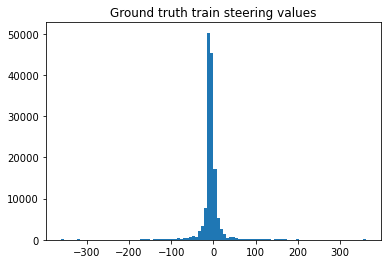

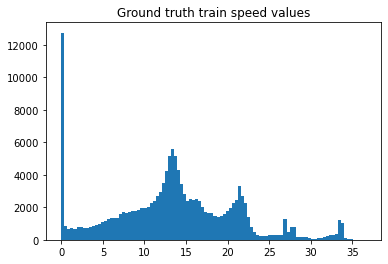

In [4]:
#Plotting distribution of train labels (Overall)
#Plotting downsampled and un-normalized train data that was used to actually train the models.
config = json.load(open(save_dir + 'config - load test data 2020-04-22-downsample.json'))

#remember that train and validation splits are shuffled - in case this is a factor in any experiment
train_loader = Drive360Loader(config, 'train')
sample_indices = train_loader.drive360.indices 
train_df = train_loader.drive360.dataframe
train_df_sampled = train_df.iloc[sample_indices,:]

train_steering_values = train_df_sampled['canSteering'].to_numpy()
train_speed_values = train_df_sampled['canSpeed'].to_numpy()

fig, ax = plt.subplots()
ax.hist(train_steering_values, bins=100)
ax.set_title("Ground truth train steering values")
plt.savefig(plots_path + 'true_train_steering.png')
plt.show()

fig, ax = plt.subplots()
ax.hist(train_speed_values, bins=100)
ax.set_title("Ground truth train speed values")
plt.savefig(plots_path + 'true_train_speed.png')
plt.show()

Loading data from ./Drive360Images_160_90/drive360challenge_split_validation_stratify.csv...
Phase: validation # of data: 11063


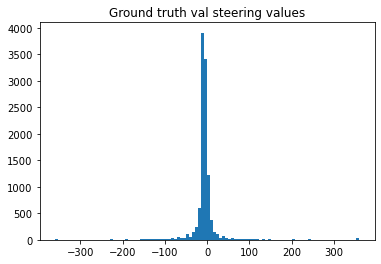

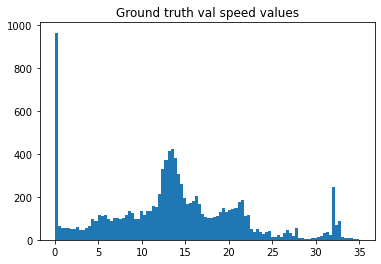

In [21]:
#Plotting distribution of validation labels (Overall) - downsampled data
config = json.load(open(save_dir + 'config - load test data 2020-04-22-downsample.json'))

validation_loader = Drive360Loader(config, 'validation')
sample_indices = validation_loader.drive360.indices 
val_df = validation_loader.drive360.dataframe
val_df_sampled = val_df.iloc[sample_indices,:]

val_steering_values = val_df_sampled['canSteering'].to_numpy()
val_speed_values = val_df_sampled['canSpeed'].to_numpy()

fig, ax = plt.subplots()
ax.hist(val_steering_values, bins=100)
ax.set_title("Ground truth val steering values")
plt.savefig(plots_path + 'true_val_steering.png')
plt.show()

fig, ax = plt.subplots()
ax.hist(val_speed_values, bins=100)
ax.set_title("Ground truth val speed values")
plt.savefig(plots_path + 'true_val_speed.png')
plt.show()

In [20]:
#Loading ground truth test data and predictions
#Plotting non downsampled un-normalized test data to compare with mse calculated on entire test dataset
config = json.load(open('./config - load test data 2020-04-22.json'))

test_loader = Drive360Loader(config, 'test')

df = test_loader.drive360.dataframe.loc[test_loader.drive360.indices]
df.reset_index(inplace=True, drop=True)

results_to_plot = [
    ('resnet34.csv', 'resnet34'),
    ('resnext101_32x4d_ssl.csv', 'resnext101_32x4d_ssl'),
    ('resnext101_32x4d_swsl.csv', 'resnext101_32x4d_swsl'),
    ('simclr.csv', 'simclr')
]

for results, label in results_to_plot:
    pred = pd.read_csv('evaluate_model_all_bottom_frozen/results/' + results)
    df['pred_speed_{}'.format(label)] = pred['canSpeed']
    df['pred_steer_{}'.format(label)] = pred['canSteering']

df.rename(columns={
    'canSpeed': 'true_speed',
    'canSteering': 'true_steer'
}, inplace=True)

routes = [n.split("/")[0] for n in df['cameraRight'].to_numpy()]
df['route'] = routes

Loading data from ./Drive360Images_160_90/drive360challenge_split_test_stratify.csv...
Phase: test # of data: 136080


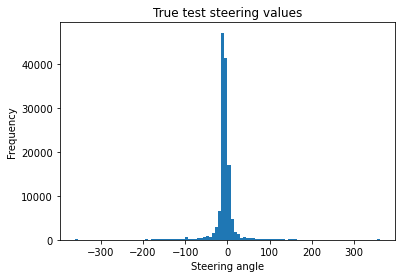

Model name -  resnet34


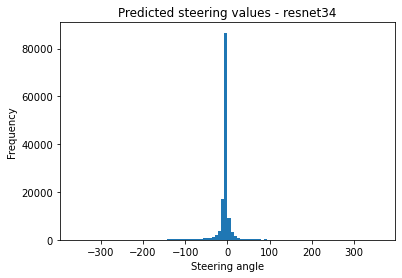

Model name -  resnext101_32x4d_ssl


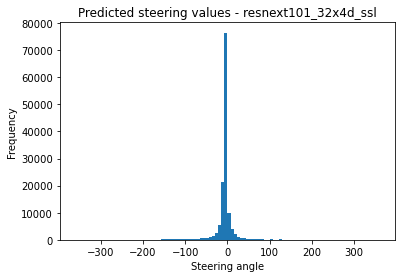

Model name -  resnext101_32x4d_swsl


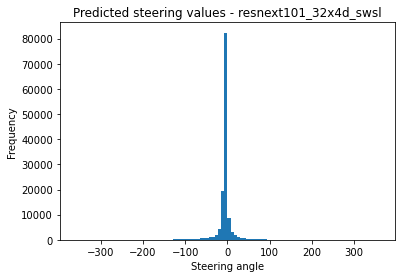

Model name -  simclr


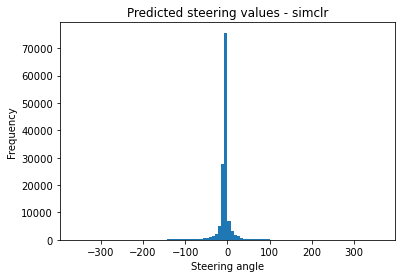

In [21]:
#Plotting distributions of ground truth and predicted values on test - Steering (Overall)
from scipy.stats import ks_2samp

true_test_steering_values = df['true_steer'].to_numpy()
true_test_steering_hist = np.histogram(true_test_steering_values, bins=100, range=(-360,360))

fig, ax = plt.subplots()
ax.hist(true_test_steering_values, bins=100, range=(-360,360))
ax.set_title("True test steering values")
ax.set_ylabel("Frequency")
ax.set_xlabel("Steering angle")
plt.savefig(plots_path + 'true_test_steering.png')
plt.show()

pred_steering_hist = {}
for results, label in results_to_plot:
    print("Model name - ", label)
    pred_steering_values = df['pred_steer_{}'.format(label)].to_numpy()
    total = len(pred_steering_values)
    pred_steering_hist[label] = np.histogram(pred_steering_values, bins=100, range=(-360,360))
    fig, ax = plt.subplots()
    ax.hist(pred_steering_values, bins=100, range=(-360,360))
    ax.set_title("Predicted steering values - {}".format(label))
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Steering angle")
    plt.savefig(plots_path + 'predicted_steering_values_{}.png'.format(label))
    plt.show()

Text(0, 0.5, 'Density')

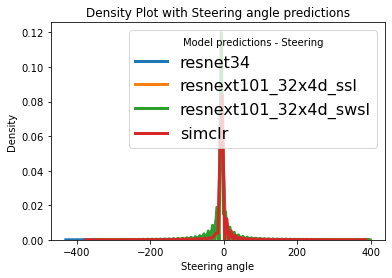

In [26]:

# for results, label in results_to_plot:
#     print("Model name - ", label)
#     pred_steering_values = df['pred_steer_{}'.format(label)].to_numpy()
#     total = len(pred_steering_values)
#     pred_steering_hist[label] = np.histogram(pred_steering_values, bins=100, range=(-360,360))
#     fig, ax = plt.subplots()
#     ax.hist(pred_steering_values, bins=100, range=(-360,360))
#     ax.set_title("Predicted steering values - {}".format(label))
#     ax.set_ylabel("Frequency")
#     ax.set_xlabel("Steering angle")
#     plt.savefig(plots_path + 'predicted_steering_values_{}.png'.format(label))
#     plt.show()
import seaborn as sns

pred_steering_hist = {}
for results, label in results_to_plot:
    pred_steering_values = df['pred_steer_{}'.format(label)].to_numpy()
    sns.distplot(pred_steering_values, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = label)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Model predictions - Steering')
plt.title('Density Plot with Steering angle predictions')
plt.xlabel('Steering angle')
plt.ylabel('Density')

In [22]:
#Compare the histograms for steering
import cv2

def np_hist_to_cv(np_histogram_output):
    counts, bin_edges = np_histogram_output
    return counts.ravel().astype('float32')

for results, label in results_to_plot:
    d = cv2.compareHist(np_hist_to_cv(true_test_steering_hist), np_hist_to_cv(pred_steering_hist[label]), cv2.HISTCMP_CHISQR)
    print("Chi square distance of {} predictions' histogram from ground truth test labels' histogram for steering - {} ".format(label, d))

Chi square distance of resnet34 predictions' histogram from ground truth test labels' histogram for steering - 76876.78511790404 
Chi square distance of resnext101_32x4d_ssl predictions' histogram from ground truth test labels' histogram for steering - 49804.33114785683 
Chi square distance of resnext101_32x4d_swsl predictions' histogram from ground truth test labels' histogram for steering - 64344.742180498455 
Chi square distance of simclr predictions' histogram from ground truth test labels' histogram for steering - 46088.41551559729 


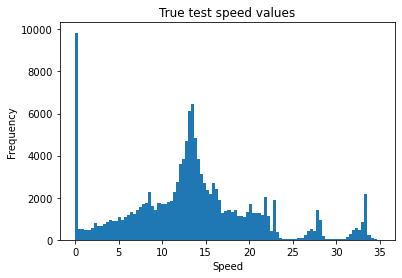

Model name -  resnet34


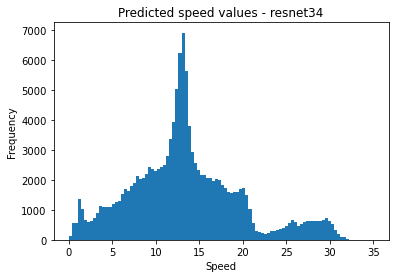

Model name -  resnext101_32x4d_ssl


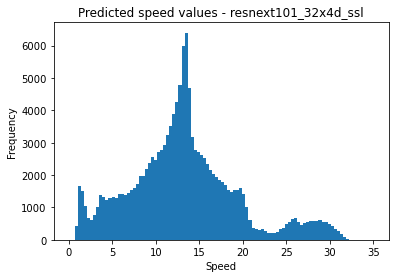

Model name -  resnext101_32x4d_swsl


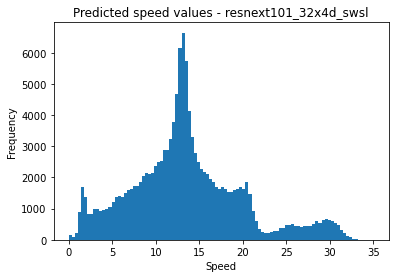

Model name -  simclr


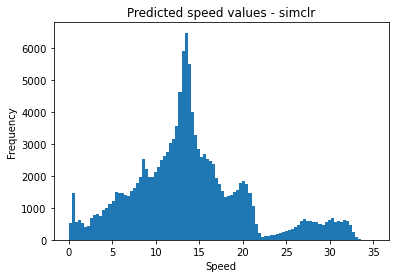

In [23]:
#Plotting distributions of ground truth and predicted values on test - Speed (Overall)
true_test_speed_values = df['true_speed'].to_numpy()
true_test_speed_hist = np.histogram(true_test_speed_values, bins=100, range=(0,35))

fig, ax = plt.subplots()
ax.hist(true_test_speed_values, bins=100, range=(0,35))
ax.set_title("True test speed values")
ax.set_ylabel("Frequency")
ax.set_xlabel("Speed")
plt.savefig(plots_path + 'true_test_speed.png')
plt.show()

pred_speed_hist = {}
for results, label in results_to_plot:
    print("Model name - ", label)
    pred_speed_values = df['pred_speed_{}'.format(label)].to_numpy()
    pred_speed_hist[label] = np.histogram(pred_speed_values, bins=100, range=(0,35))
    fig, ax = plt.subplots()
    ax.hist(pred_speed_values, bins=100, range=(0,35))
    ax.set_title("Predicted speed values - {}".format(label))
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Speed")
    plt.savefig(plots_path + 'predicted_speed_values_{}.png'.format(label))
    plt.show()

In [24]:
#Compare the histograms for speed
import cv2

def np_hist_to_cv(np_histogram_output):
    counts, bin_edges = np_histogram_output
    return counts.ravel().astype('float32')

for results, label in results_to_plot:
    d = cv2.compareHist(np_hist_to_cv(true_test_speed_hist), np_hist_to_cv(pred_speed_hist[label]), cv2.HISTCMP_CHISQR)
    print("Chi square distance of {} predictions' histogram from ground truth test labels' histogram for speed - {} ".format(label, d))

Chi square distance of resnet34 predictions' histogram from ground truth test labels' histogram for speed - 99661.81631247443 
Chi square distance of resnext101_32x4d_ssl predictions' histogram from ground truth test labels' histogram for speed - 91746.23946172785 
Chi square distance of resnext101_32x4d_swsl predictions' histogram from ground truth test labels' histogram for speed - 100898.69882115672 
Chi square distance of simclr predictions' histogram from ground truth test labels' histogram for speed - 79876.21868900249 


In [14]:
#Plotting route level distributions
def plot_route_level_histograms(df, route, models_to_plot):
    df_route = df.loc[df['route'] == route]
    #Plotting ground truth steering for route
    true_test_steering_values = df_route['true_steer'].to_numpy()
    fig, ax = plt.subplots()
    ax.hist(true_test_steering_values, bins=100)
    ax.set_title("True test steering values for route - {}".format(route))
    plt.savefig(plots_path + 'true_test_steering_{}.png'.format(route))
    plt.show()
    #Predicted steering values for route
    for label in models_to_plot:
        print("Model name - ", label)
        pred_steering_values = df_route['pred_steer_{}'.format(label)].to_numpy()      
        fig, ax = plt.subplots()
        ax.hist(pred_steering_values, bins=100)
        ax.set_title("Predicted steering values of {} for route {}".format(label, route))
        plt.savefig(plots_path + 'predicted_steering_values_{}_{}.png'.format(label, route))
        plt.show()
        
    #Ground truth speed for route
    true_test_speed_values = df_route['true_speed'].to_numpy()
    fig, ax = plt.subplots()
    ax.hist(true_test_speed_values, bins=100)
    ax.set_title("True test speed values for route - {}".format(route))
    plt.savefig(plots_path + 'true_test_speed_{}.png'.format(route))
    plt.show()
    #Predicted speed values for route
    for label in models_to_plot:
        print("Model name - ", label)
        pred_speed_values = df_route['pred_speed_{}'.format(label)].to_numpy()
        fig, ax = plt.subplots()
        ax.hist(pred_speed_values, bins=100)
        ax.set_title("Predicted speed values of {} for route {}".format(label, route))
        plt.savefig(plots_path + 'predicted_speed_values_{}_{}.png'.format(label, route))
        plt.show()

In [15]:
#List of all the routes which can be passed to above function
route_list = set(df['route'].to_numpy())
print("All routes - ", route_list)

All routes -  {'Neuchatel', 'Zurich_6', 'ECCV_Test_4', 'Appenzell', 'Schaffhausen', 'Appenzell_3', 'Bern', 'Zurich_4', 'Zurich_3', 'Flims', 'Flims_2', 'Aargau', 'Zurich_8', 'Laufenburg', 'Appenzell_2', 'Lachen_2', 'Emmen', 'Zurich', 'Zurich_5', 'Andelfingen', 'Lachen', 'Egg', 'Zurich_2', 'Luzern'}


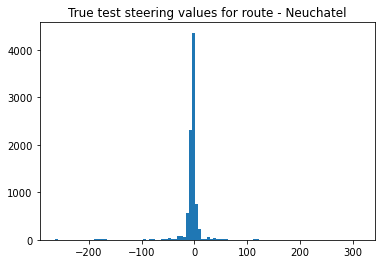

Model name -  resnet34


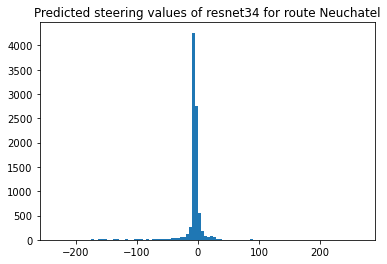

Model name -  resnext101_32x4d_ssl


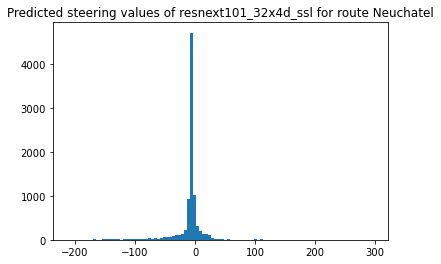

Model name -  resnext101_32x4d_swsl


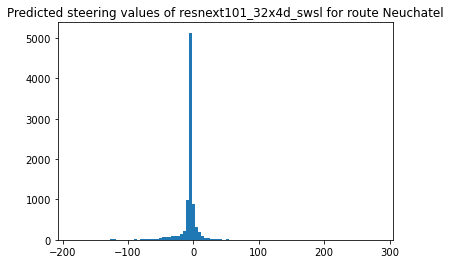

Model name -  simclr


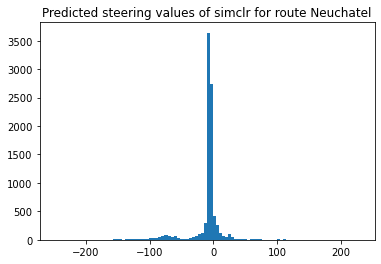

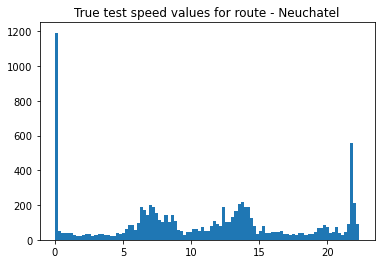

Model name -  resnet34


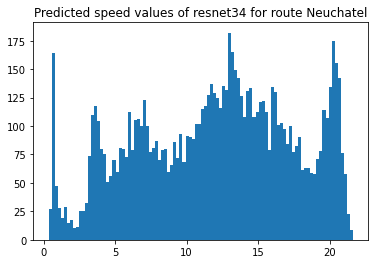

Model name -  resnext101_32x4d_ssl


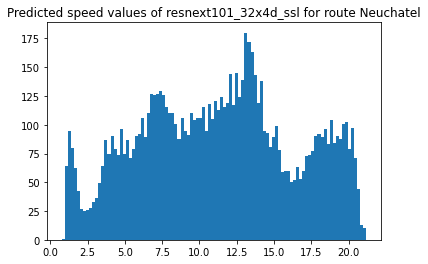

Model name -  resnext101_32x4d_swsl


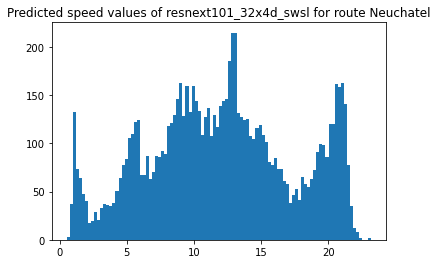

Model name -  simclr


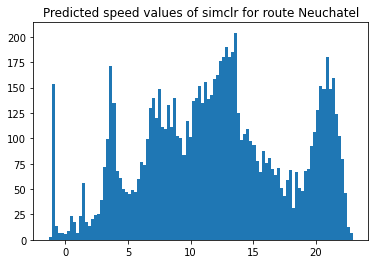

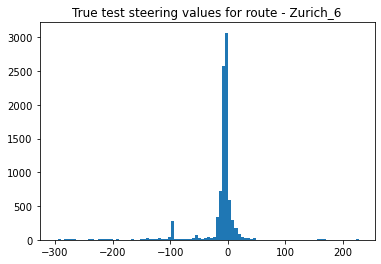

Model name -  resnet34


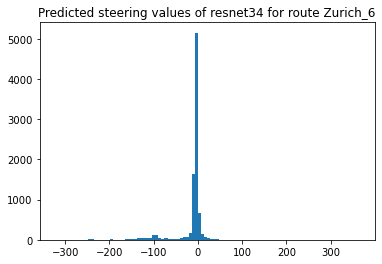

Model name -  resnext101_32x4d_ssl


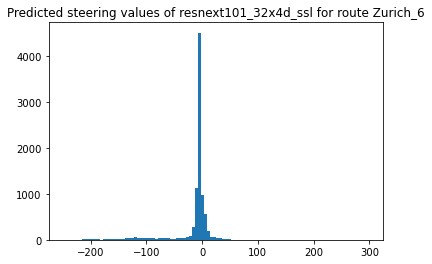

Model name -  resnext101_32x4d_swsl


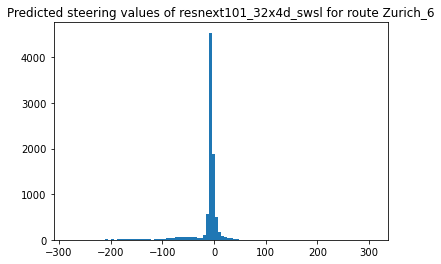

Model name -  simclr


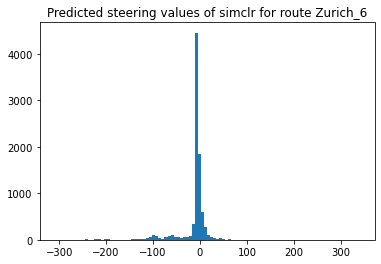

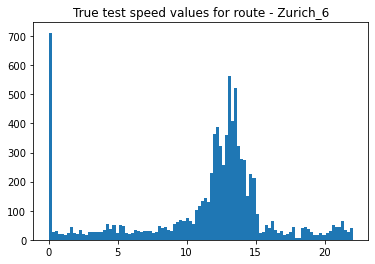

Model name -  resnet34


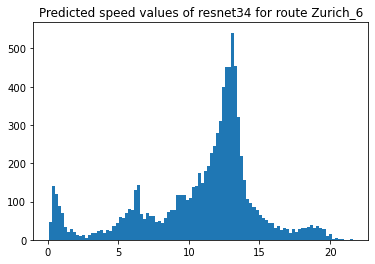

Model name -  resnext101_32x4d_ssl


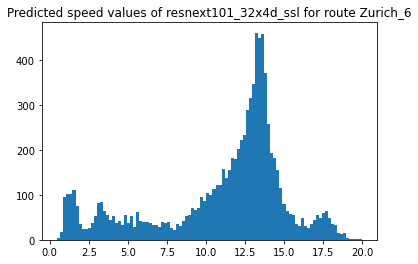

Model name -  resnext101_32x4d_swsl


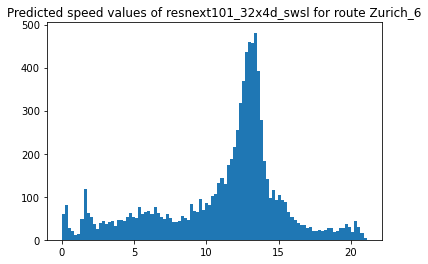

Model name -  simclr


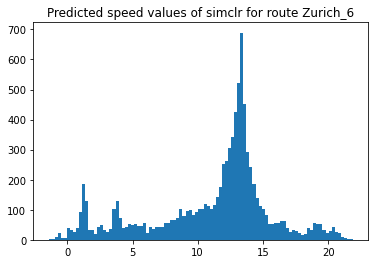

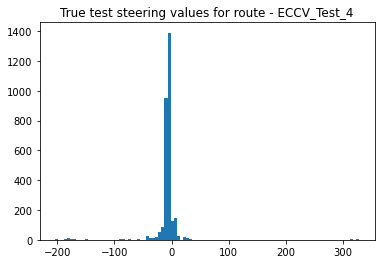

Model name -  resnet34


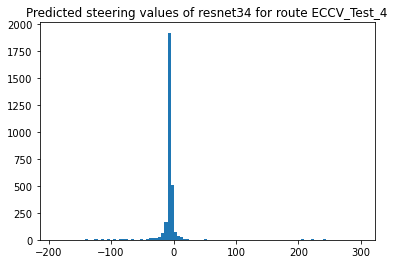

Model name -  resnext101_32x4d_ssl


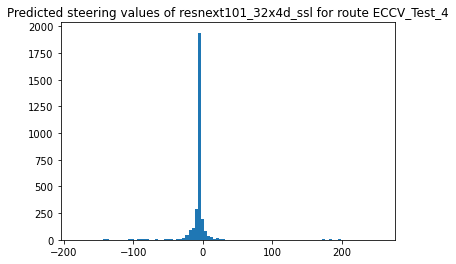

Model name -  resnext101_32x4d_swsl


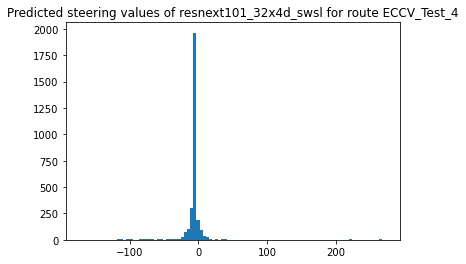

Model name -  simclr


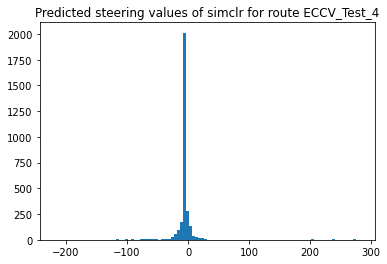

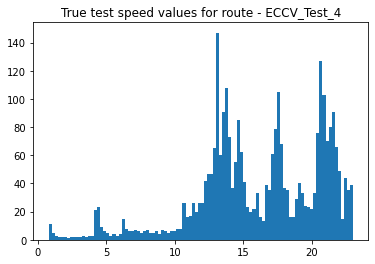

Model name -  resnet34


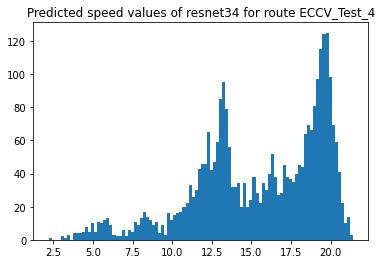

Model name -  resnext101_32x4d_ssl


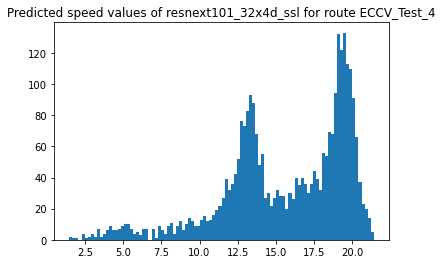

Model name -  resnext101_32x4d_swsl


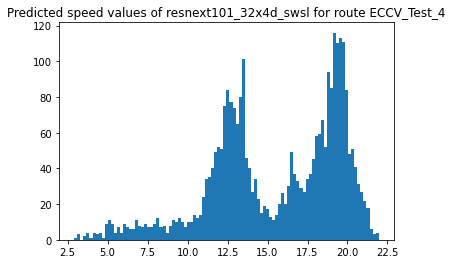

Model name -  simclr


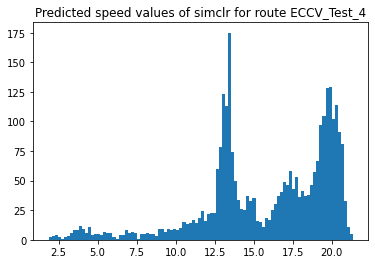

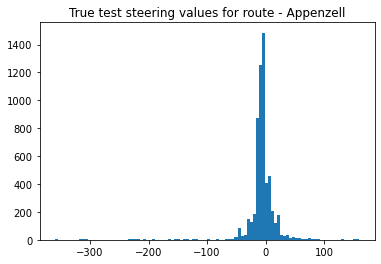

Model name -  resnet34


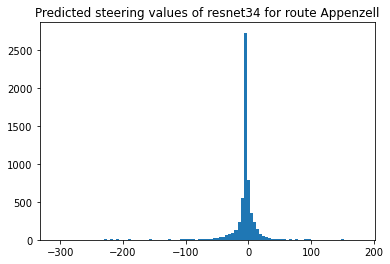

Model name -  resnext101_32x4d_ssl


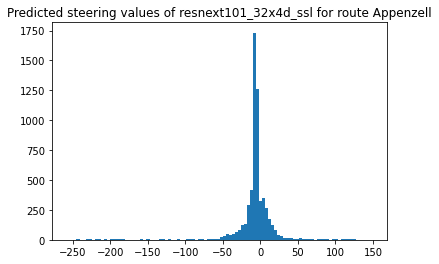

Model name -  resnext101_32x4d_swsl


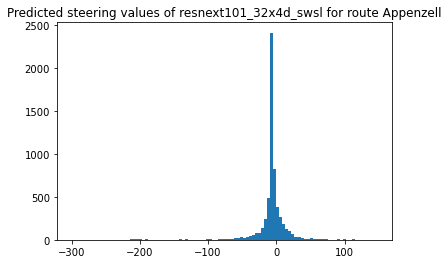

Model name -  simclr


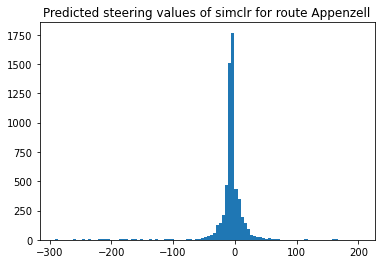

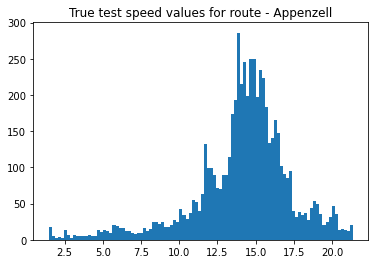

Model name -  resnet34


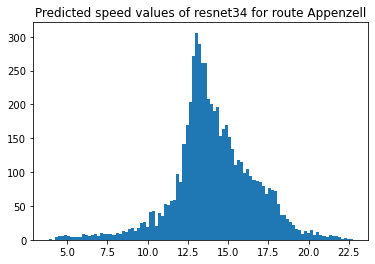

Model name -  resnext101_32x4d_ssl


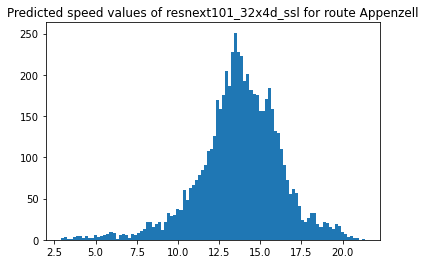

Model name -  resnext101_32x4d_swsl


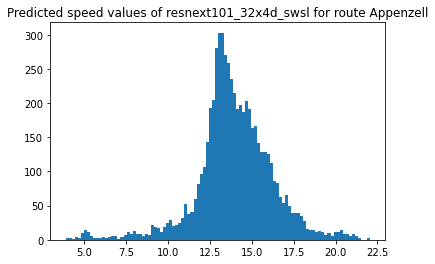

Model name -  simclr


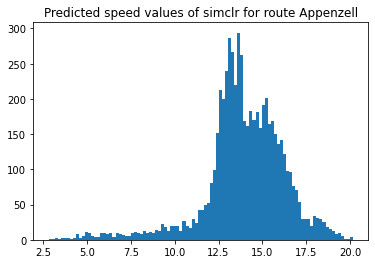

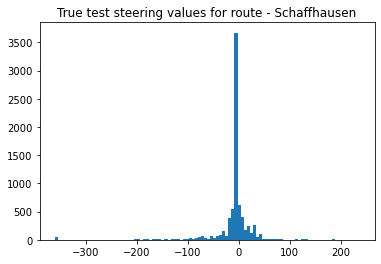

Model name -  resnet34


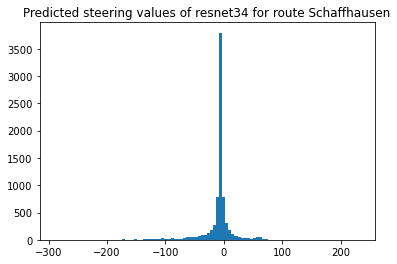

Model name -  resnext101_32x4d_ssl


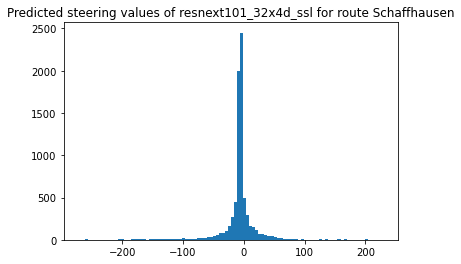

Model name -  resnext101_32x4d_swsl


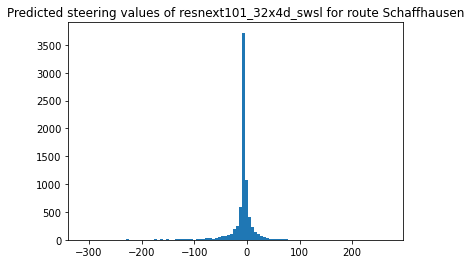

Model name -  simclr


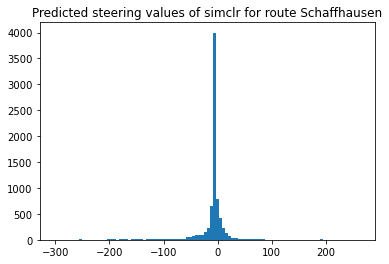

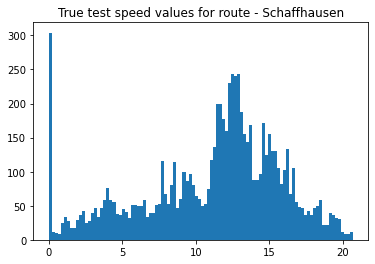

Model name -  resnet34


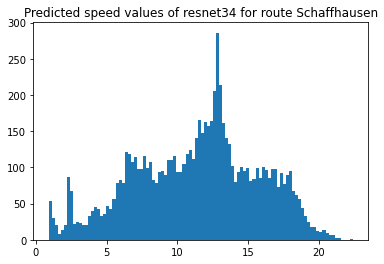

Model name -  resnext101_32x4d_ssl


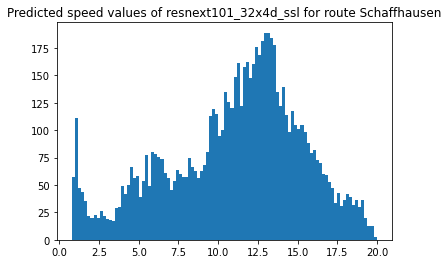

Model name -  resnext101_32x4d_swsl


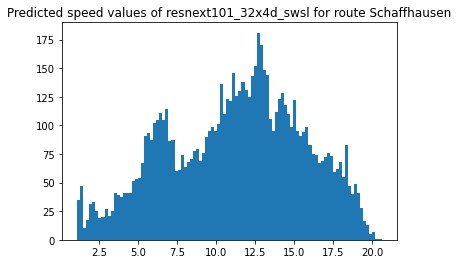

Model name -  simclr


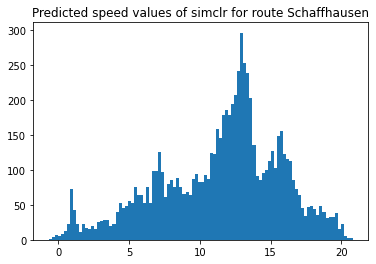

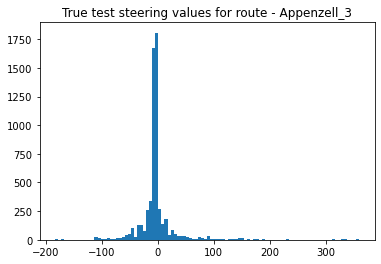

Model name -  resnet34


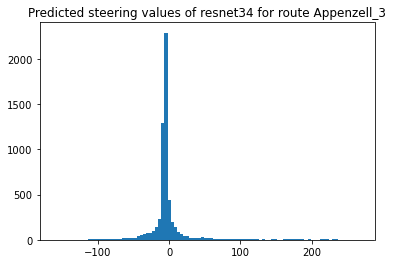

Model name -  resnext101_32x4d_ssl


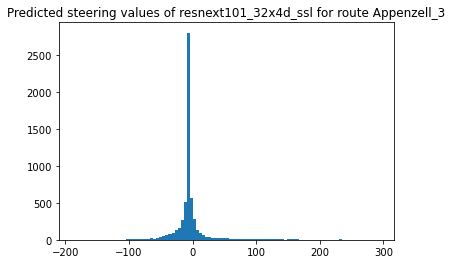

Model name -  resnext101_32x4d_swsl


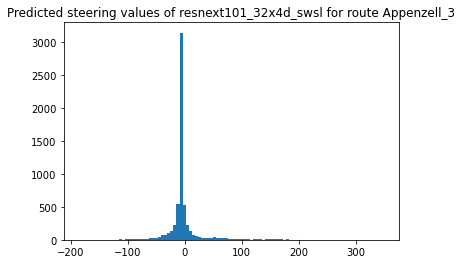

Model name -  simclr


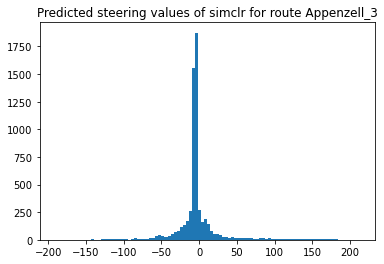

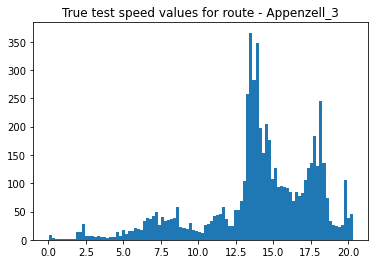

Model name -  resnet34


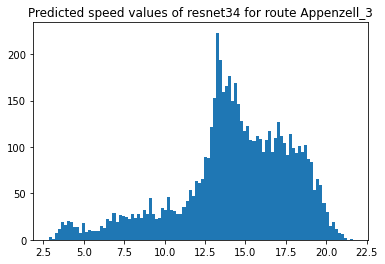

Model name -  resnext101_32x4d_ssl


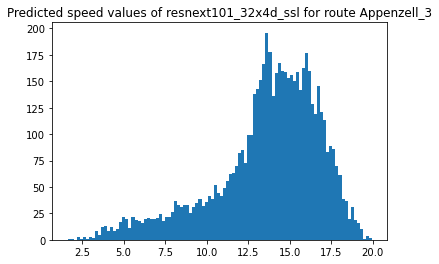

Model name -  resnext101_32x4d_swsl


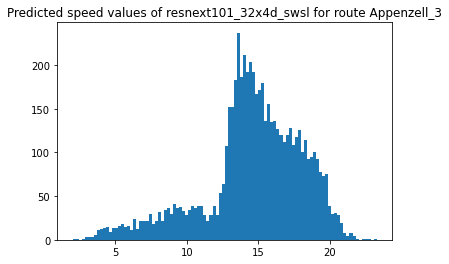

Model name -  simclr


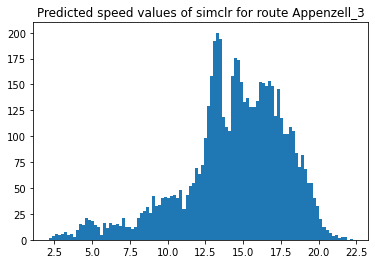

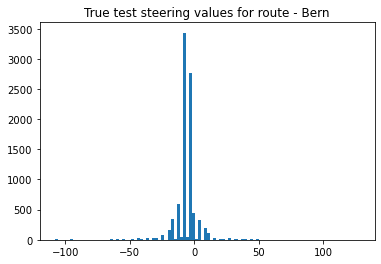

Model name -  resnet34


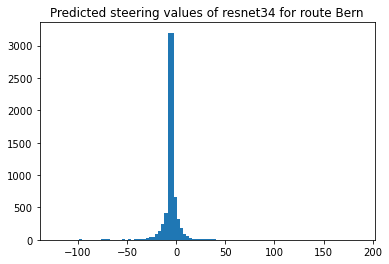

Model name -  resnext101_32x4d_ssl


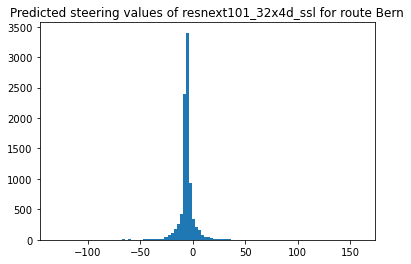

Model name -  resnext101_32x4d_swsl


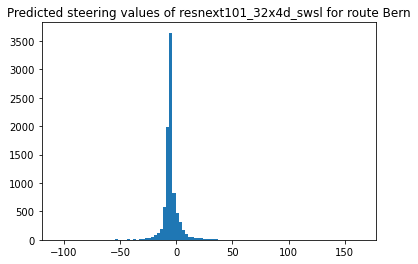

Model name -  simclr


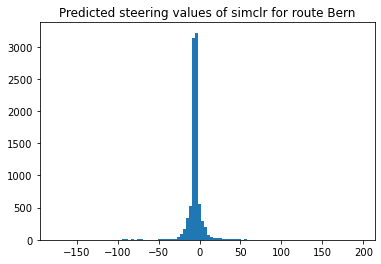

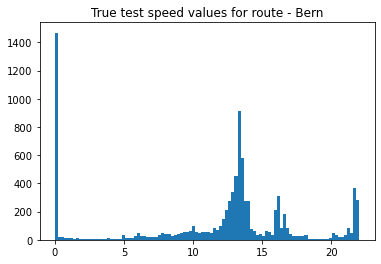

Model name -  resnet34


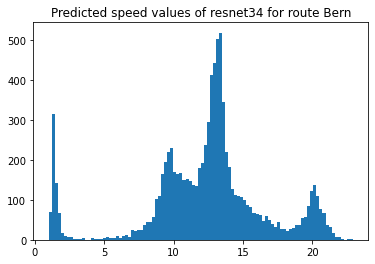

Model name -  resnext101_32x4d_ssl


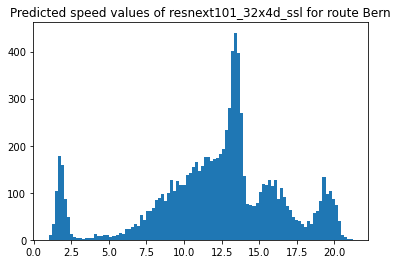

Model name -  resnext101_32x4d_swsl


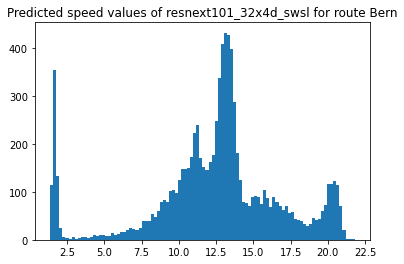

Model name -  simclr


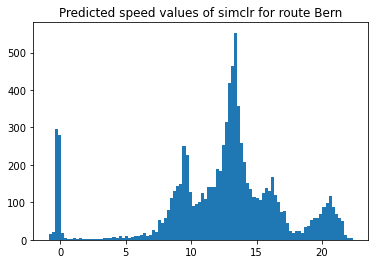

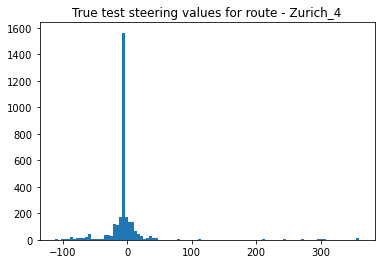

Model name -  resnet34


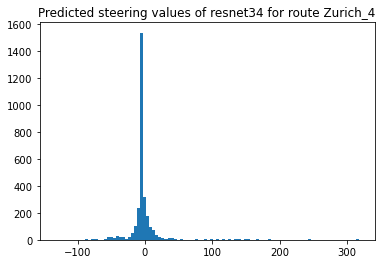

Model name -  resnext101_32x4d_ssl


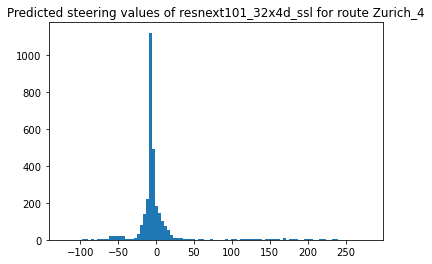

Model name -  resnext101_32x4d_swsl


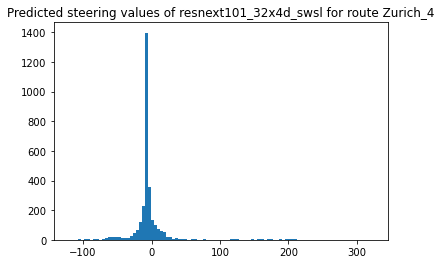

Model name -  simclr


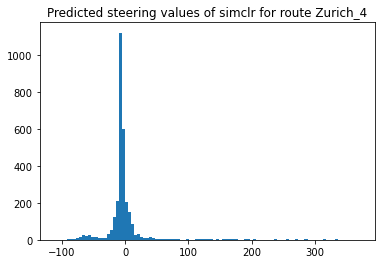

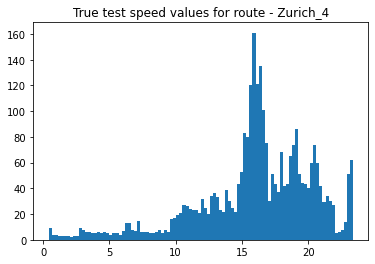

Model name -  resnet34


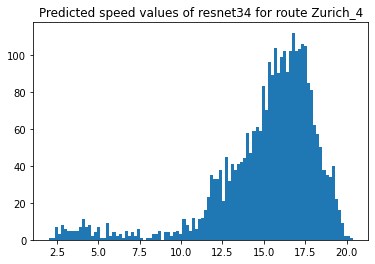

Model name -  resnext101_32x4d_ssl


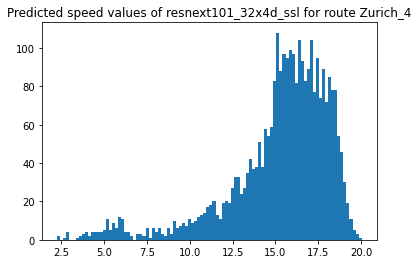

Model name -  resnext101_32x4d_swsl


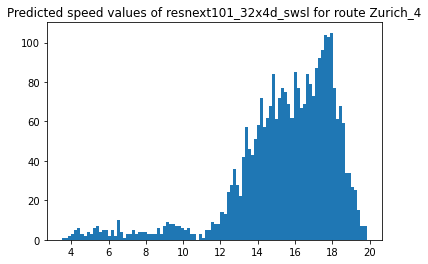

Model name -  simclr


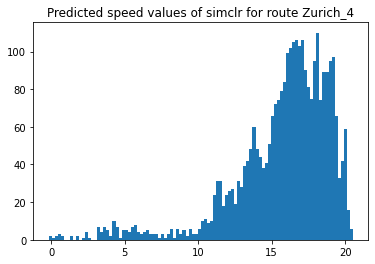

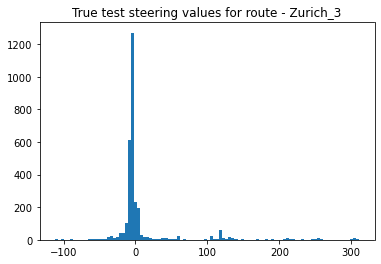

Model name -  resnet34


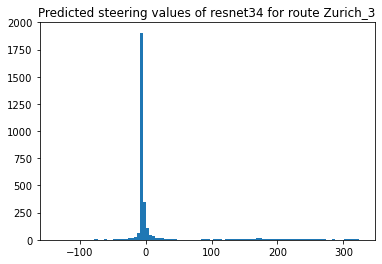

Model name -  resnext101_32x4d_ssl


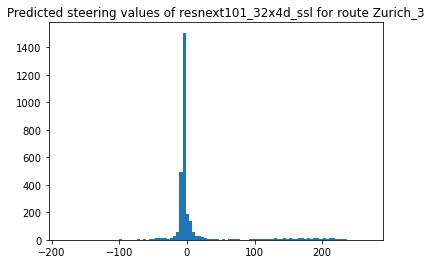

Model name -  resnext101_32x4d_swsl


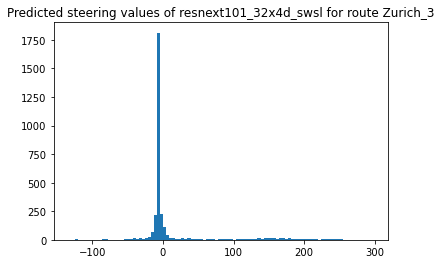

Model name -  simclr


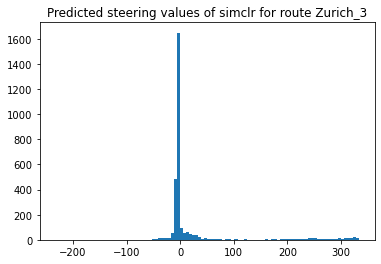

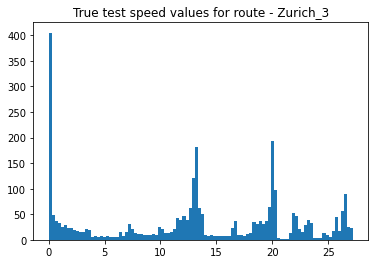

Model name -  resnet34


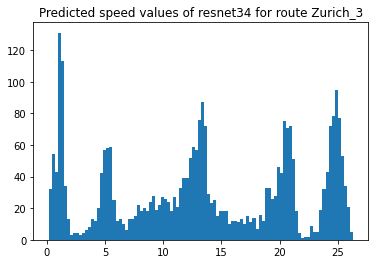

Model name -  resnext101_32x4d_ssl


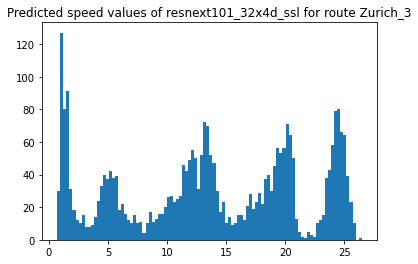

Model name -  resnext101_32x4d_swsl


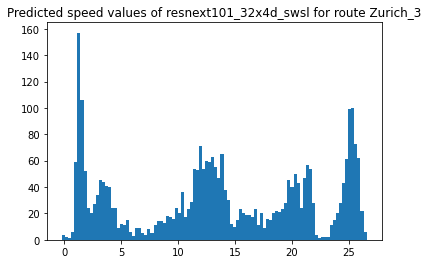

Model name -  simclr


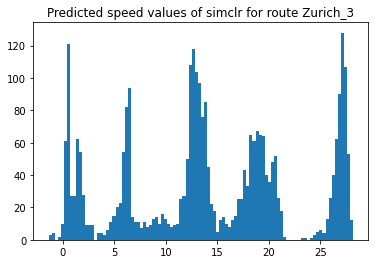

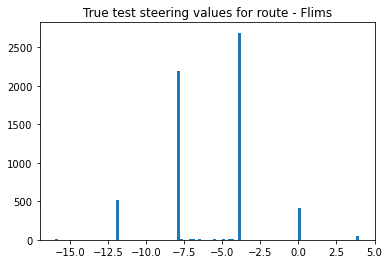

Model name -  resnet34


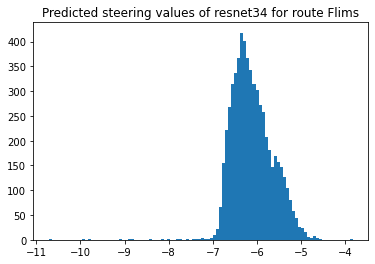

Model name -  resnext101_32x4d_ssl


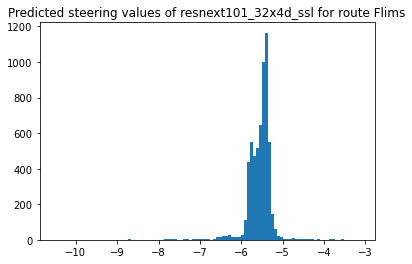

Model name -  resnext101_32x4d_swsl


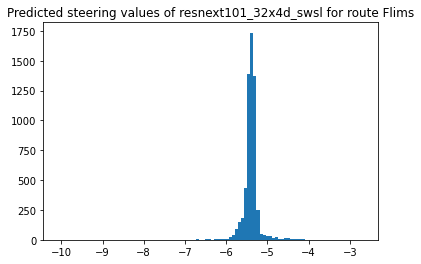

Model name -  simclr


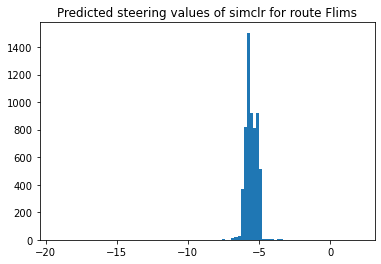

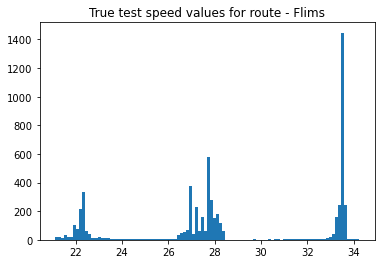

Model name -  resnet34


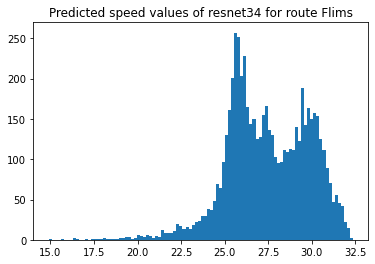

Model name -  resnext101_32x4d_ssl


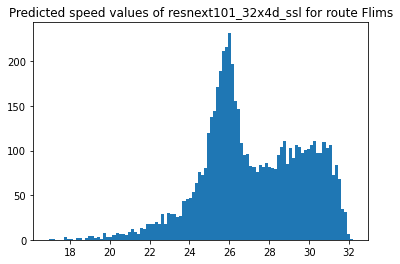

Model name -  resnext101_32x4d_swsl


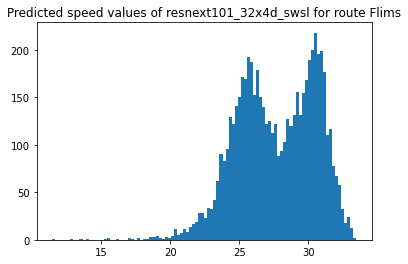

Model name -  simclr


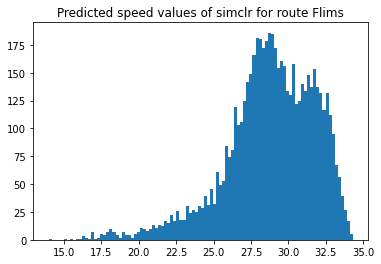

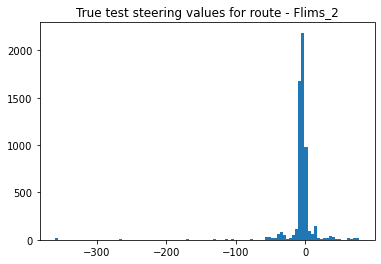

Model name -  resnet34


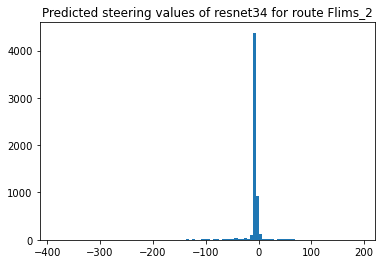

Model name -  resnext101_32x4d_ssl


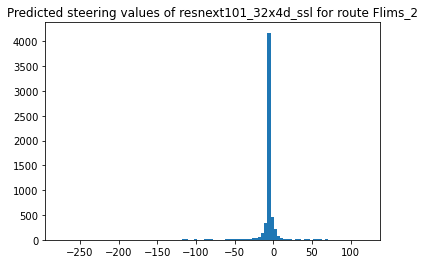

Model name -  resnext101_32x4d_swsl


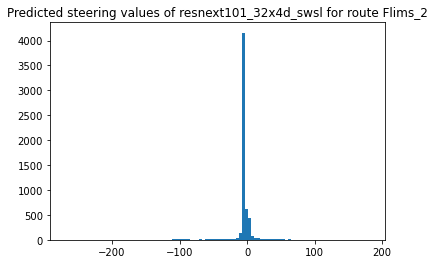

Model name -  simclr


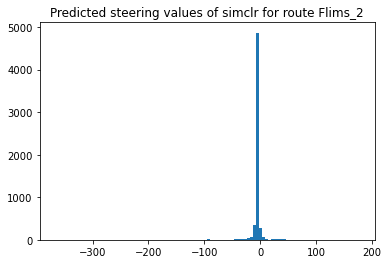

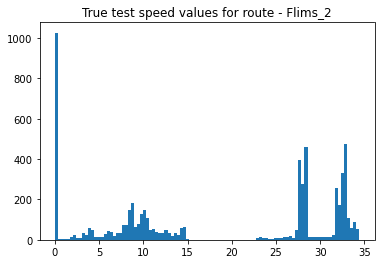

Model name -  resnet34


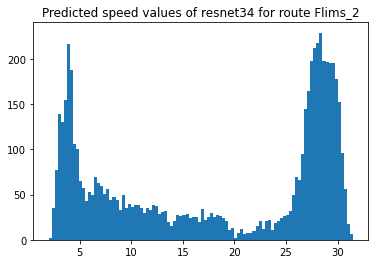

Model name -  resnext101_32x4d_ssl


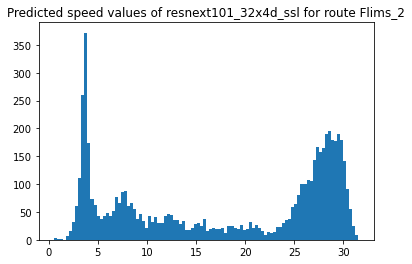

Model name -  resnext101_32x4d_swsl


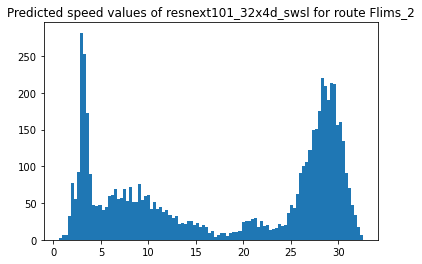

Model name -  simclr


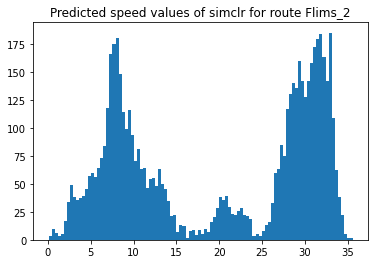

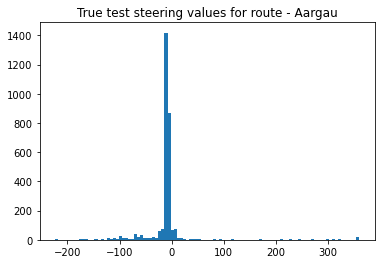

Model name -  resnet34


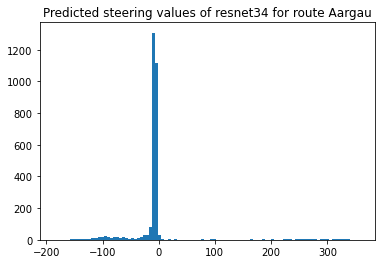

Model name -  resnext101_32x4d_ssl


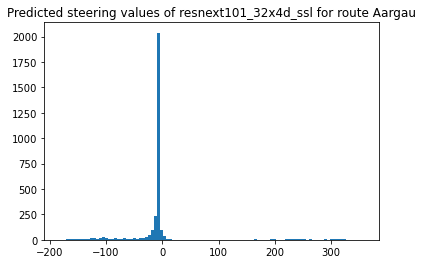

Model name -  resnext101_32x4d_swsl


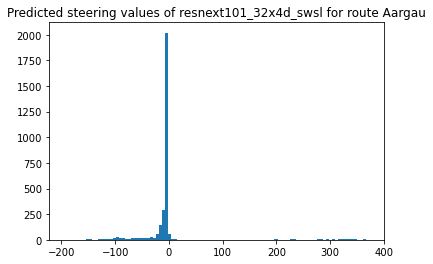

Model name -  simclr


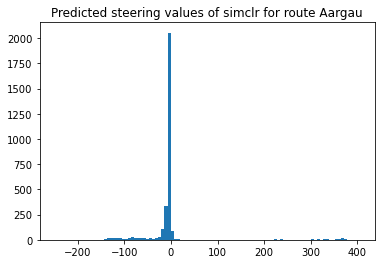

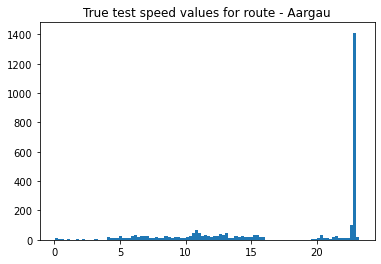

Model name -  resnet34


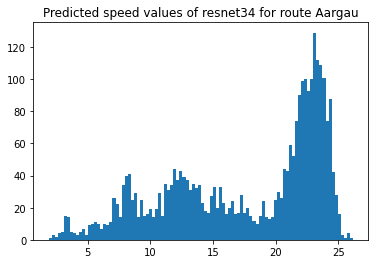

Model name -  resnext101_32x4d_ssl


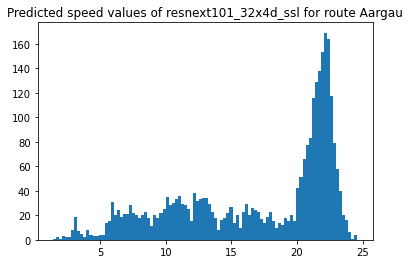

Model name -  resnext101_32x4d_swsl


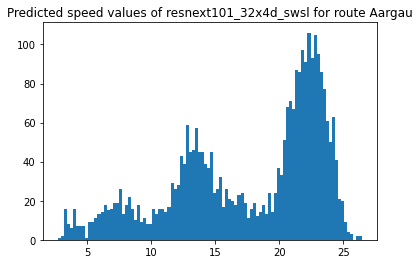

Model name -  simclr


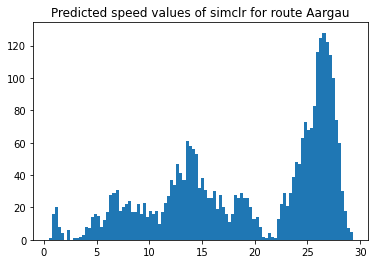

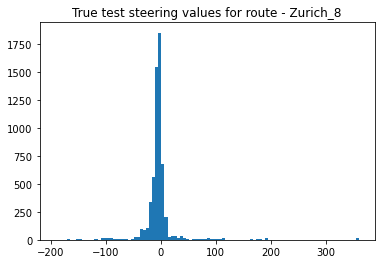

Model name -  resnet34


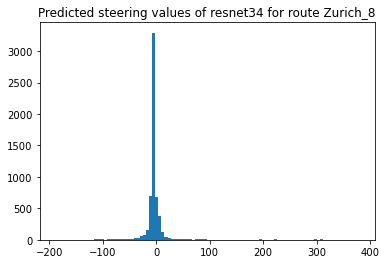

Model name -  resnext101_32x4d_ssl


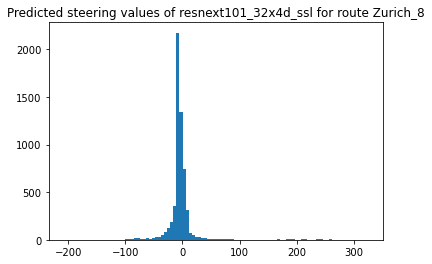

Model name -  resnext101_32x4d_swsl


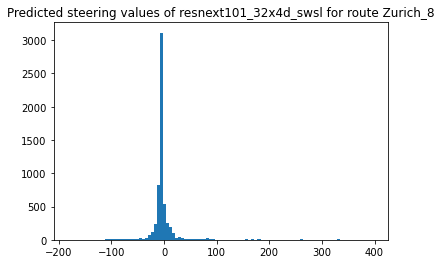

Model name -  simclr


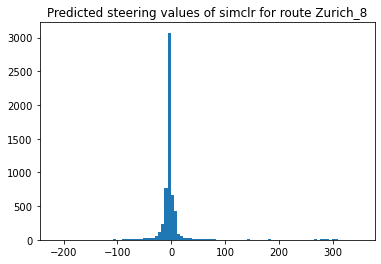

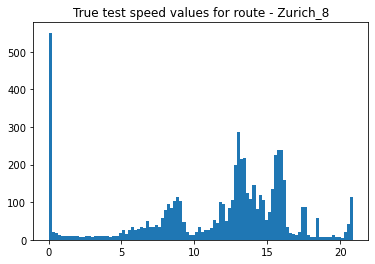

Model name -  resnet34


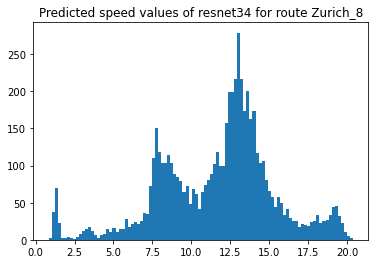

Model name -  resnext101_32x4d_ssl


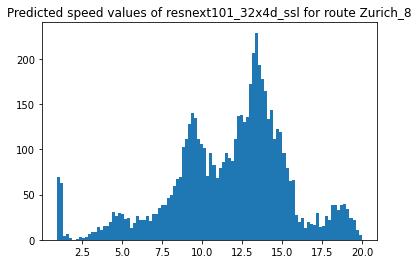

Model name -  resnext101_32x4d_swsl


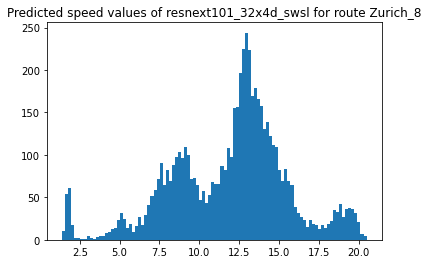

Model name -  simclr


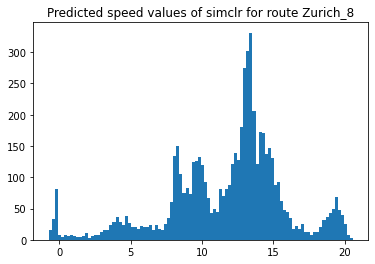

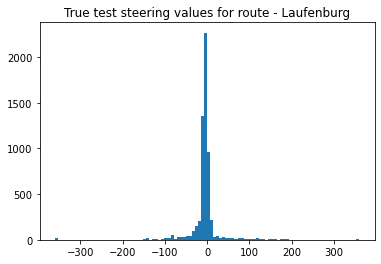

Model name -  resnet34


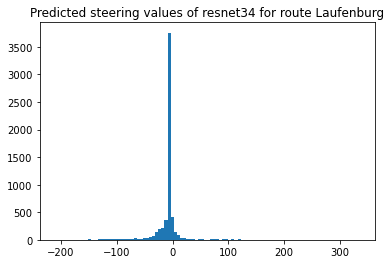

Model name -  resnext101_32x4d_ssl


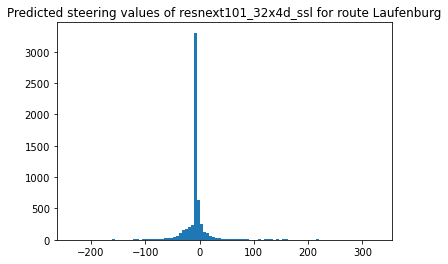

Model name -  resnext101_32x4d_swsl


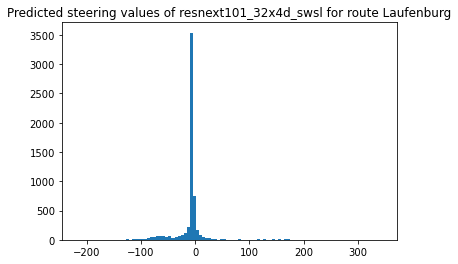

Model name -  simclr


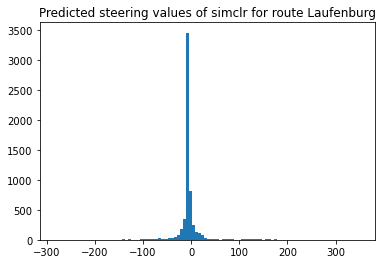

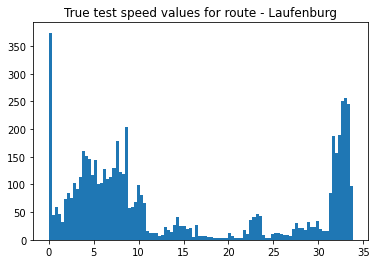

Model name -  resnet34


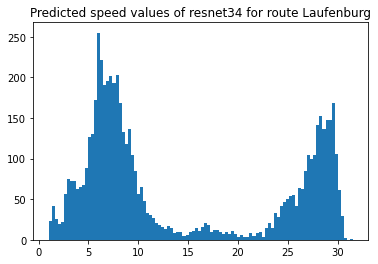

Model name -  resnext101_32x4d_ssl


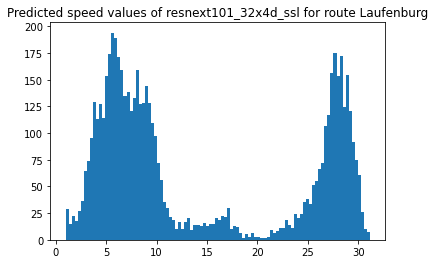

Model name -  resnext101_32x4d_swsl


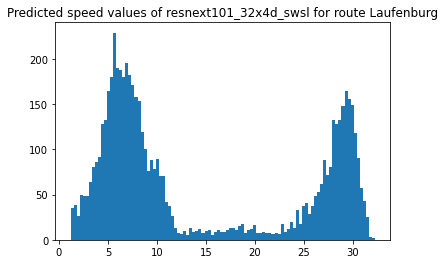

Model name -  simclr


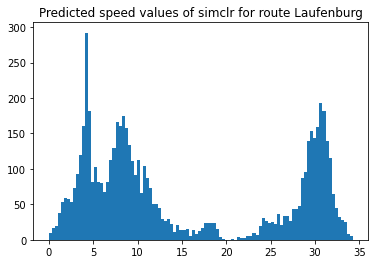

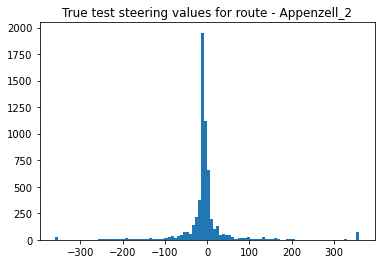

Model name -  resnet34


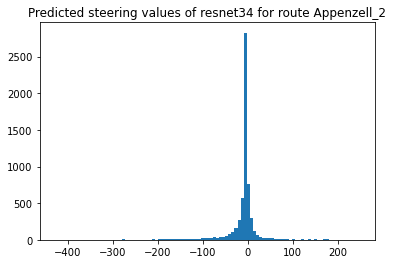

Model name -  resnext101_32x4d_ssl


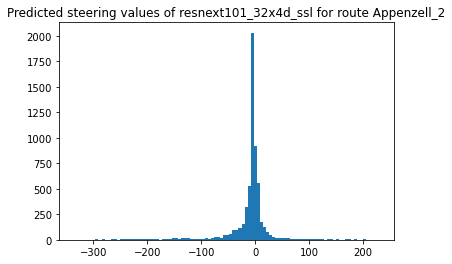

Model name -  resnext101_32x4d_swsl


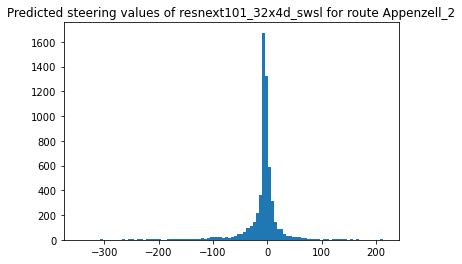

Model name -  simclr


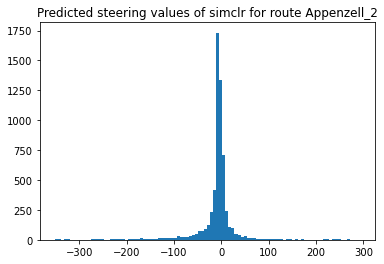

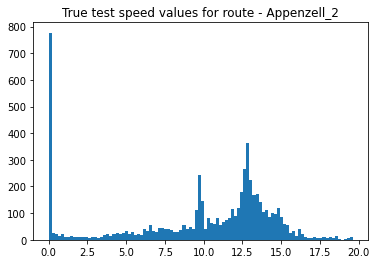

Model name -  resnet34


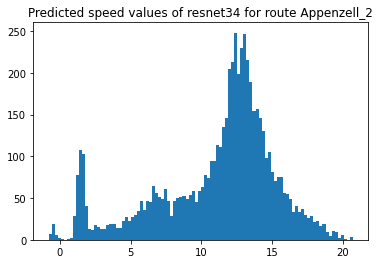

Model name -  resnext101_32x4d_ssl


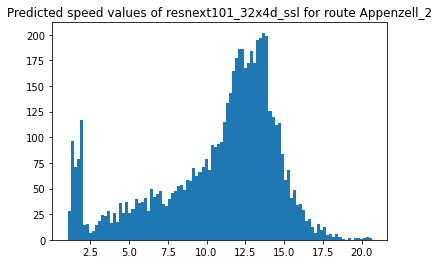

Model name -  resnext101_32x4d_swsl


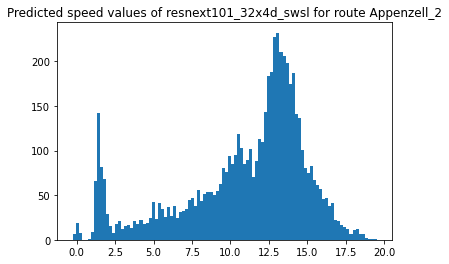

Model name -  simclr


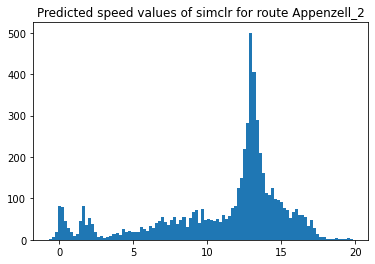

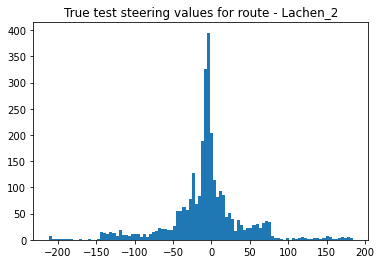

Model name -  resnet34


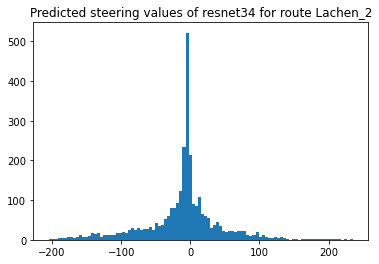

Model name -  resnext101_32x4d_ssl


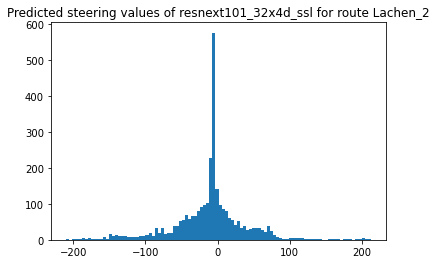

Model name -  resnext101_32x4d_swsl


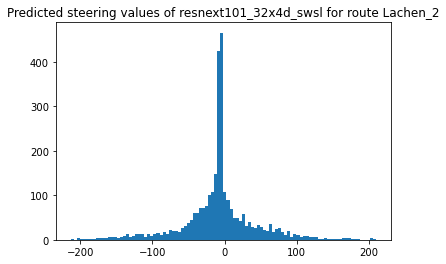

Model name -  simclr


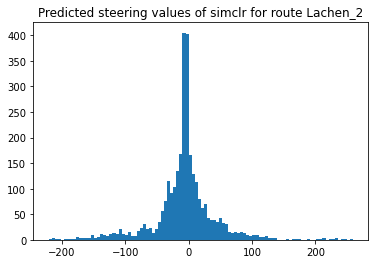

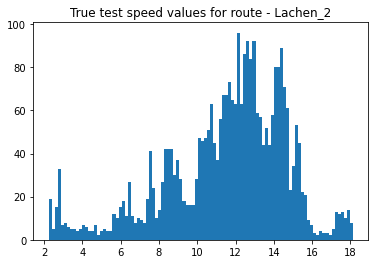

Model name -  resnet34


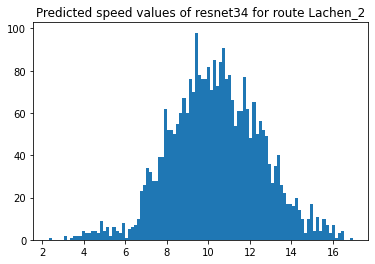

Model name -  resnext101_32x4d_ssl


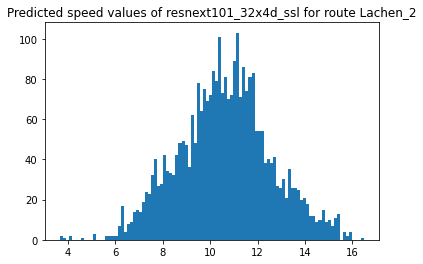

Model name -  resnext101_32x4d_swsl


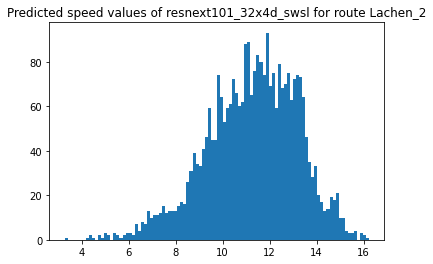

Model name -  simclr


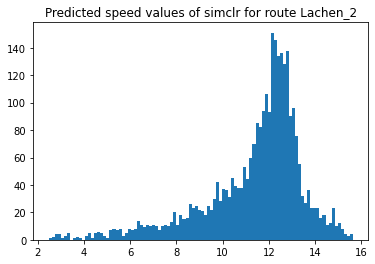

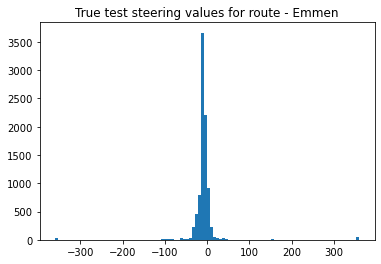

Model name -  resnet34


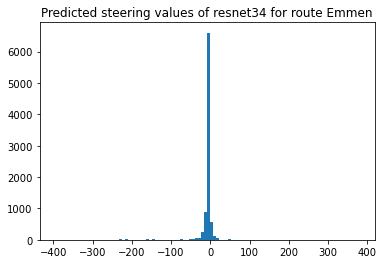

Model name -  resnext101_32x4d_ssl


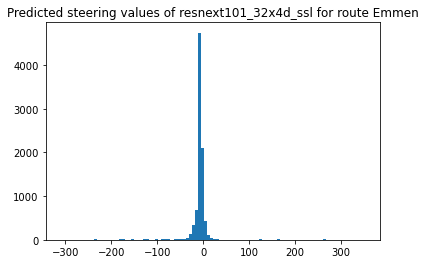

Model name -  resnext101_32x4d_swsl


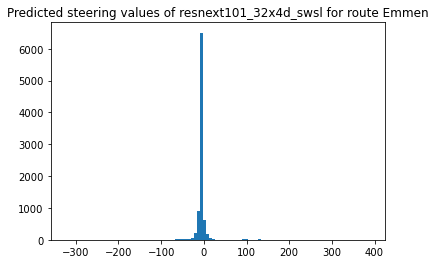

Model name -  simclr


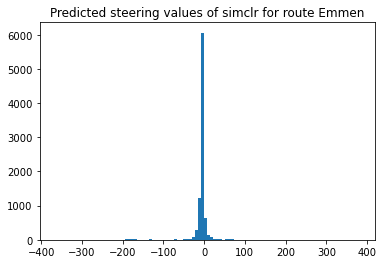

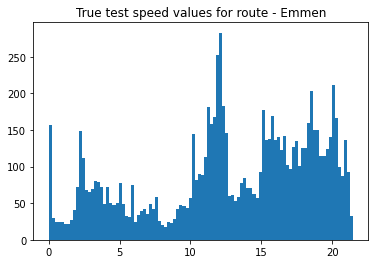

Model name -  resnet34


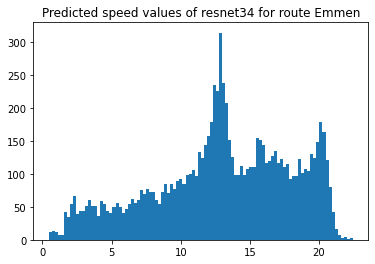

Model name -  resnext101_32x4d_ssl


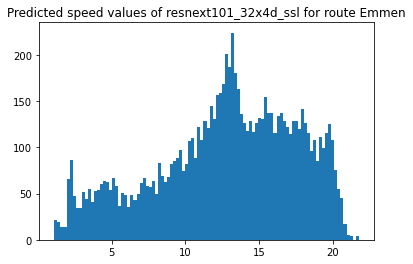

Model name -  resnext101_32x4d_swsl


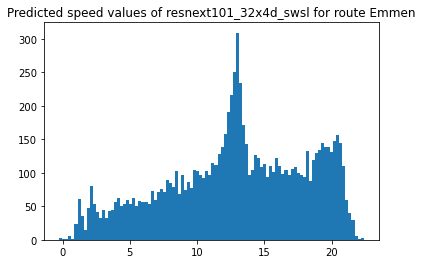

Model name -  simclr


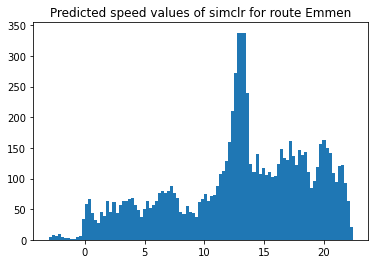

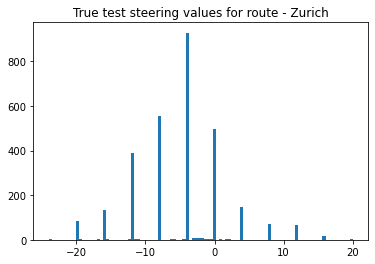

Model name -  resnet34


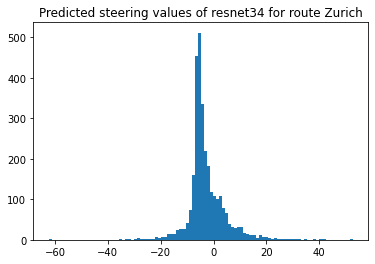

Model name -  resnext101_32x4d_ssl


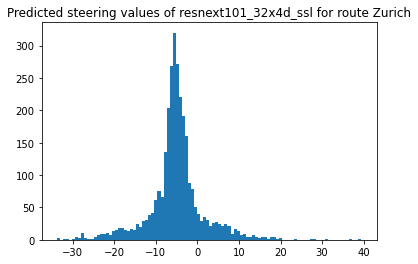

Model name -  resnext101_32x4d_swsl


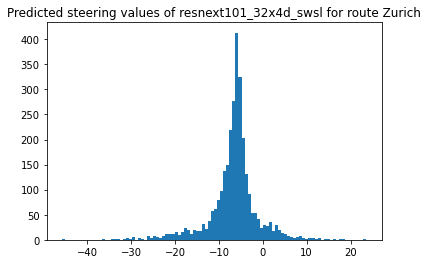

Model name -  simclr


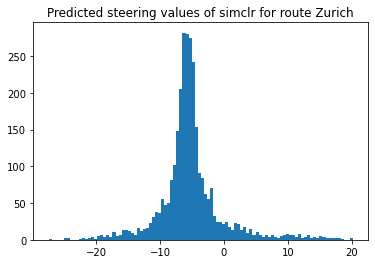

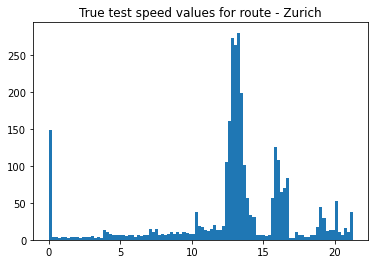

Model name -  resnet34


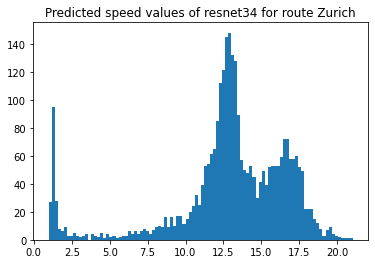

Model name -  resnext101_32x4d_ssl


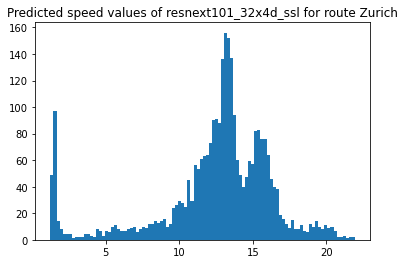

Model name -  resnext101_32x4d_swsl


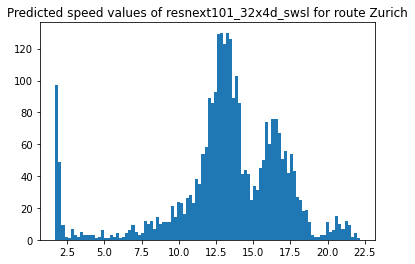

Model name -  simclr


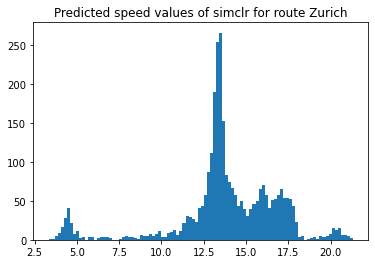

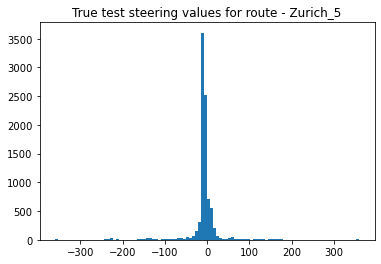

Model name -  resnet34


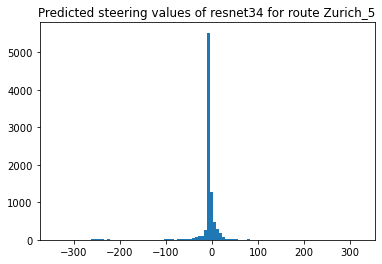

Model name -  resnext101_32x4d_ssl


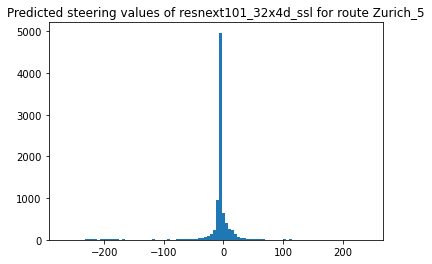

Model name -  resnext101_32x4d_swsl


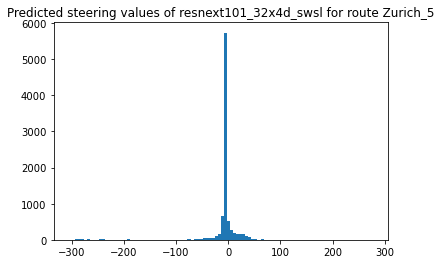

Model name -  simclr


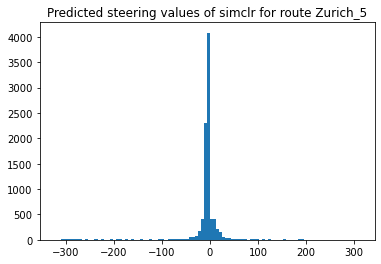

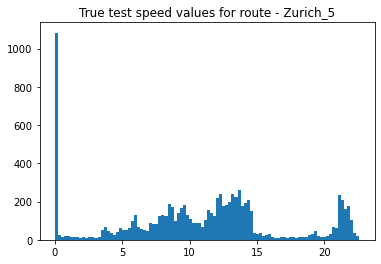

Model name -  resnet34


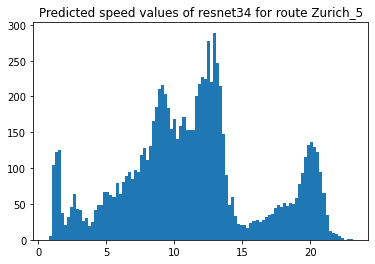

Model name -  resnext101_32x4d_ssl


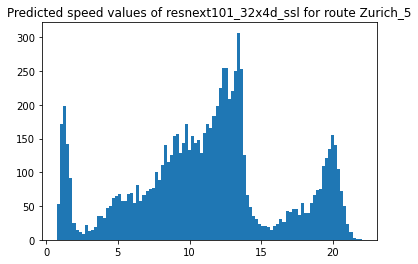

Model name -  resnext101_32x4d_swsl


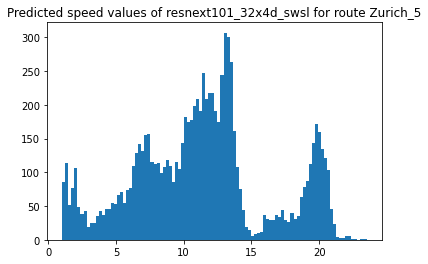

Model name -  simclr


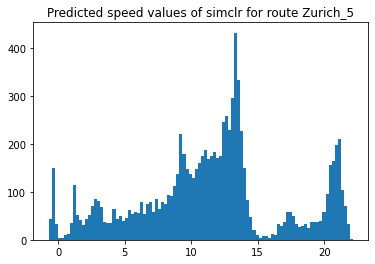

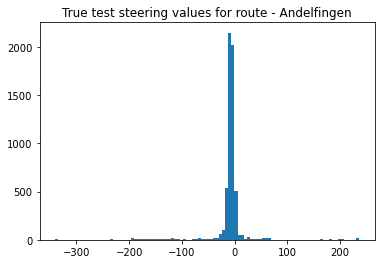

Model name -  resnet34


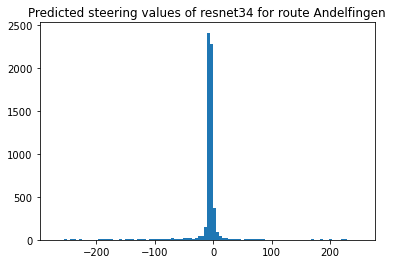

Model name -  resnext101_32x4d_ssl


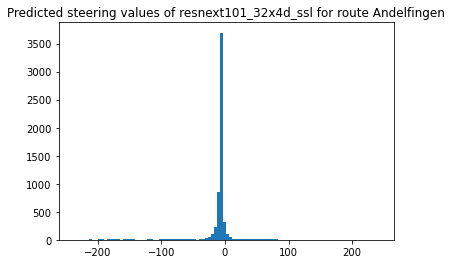

Model name -  resnext101_32x4d_swsl


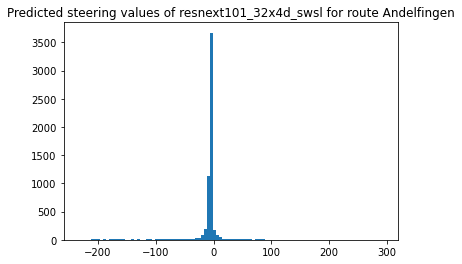

Model name -  simclr


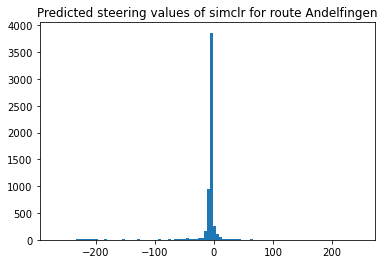

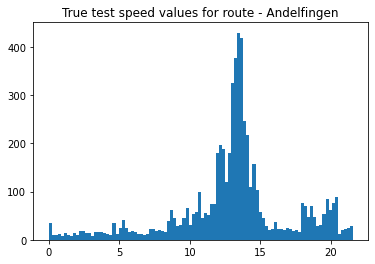

Model name -  resnet34


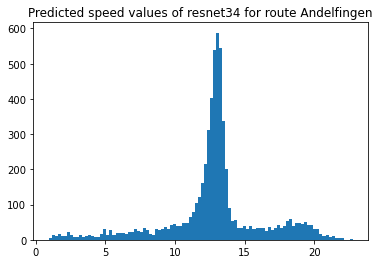

Model name -  resnext101_32x4d_ssl


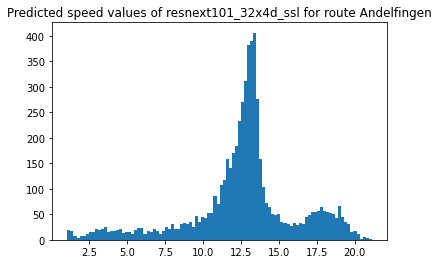

Model name -  resnext101_32x4d_swsl


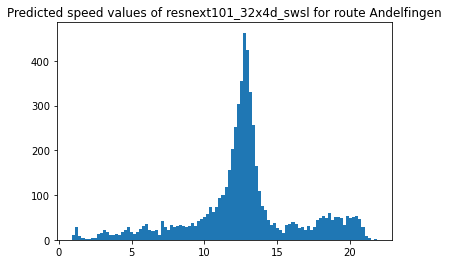

Model name -  simclr


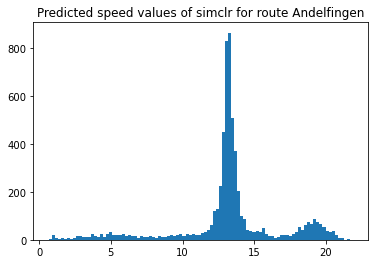

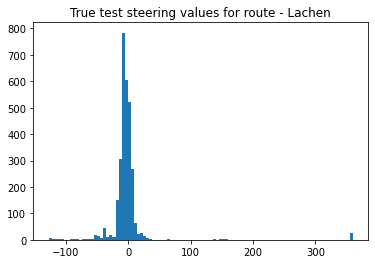

Model name -  resnet34


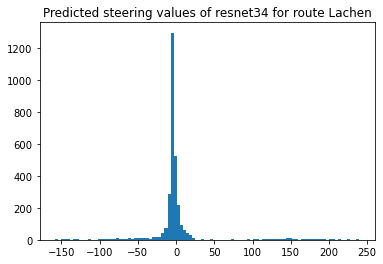

Model name -  resnext101_32x4d_ssl


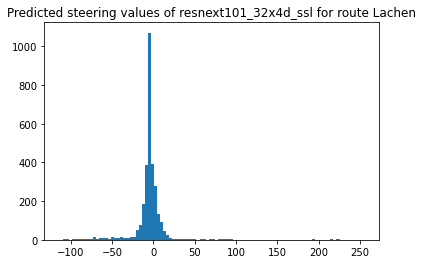

Model name -  resnext101_32x4d_swsl


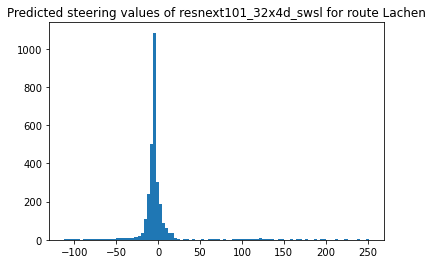

Model name -  simclr


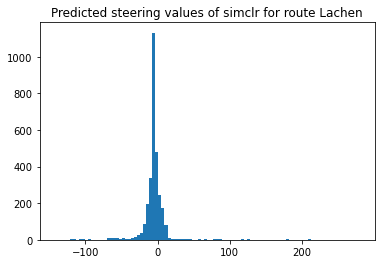

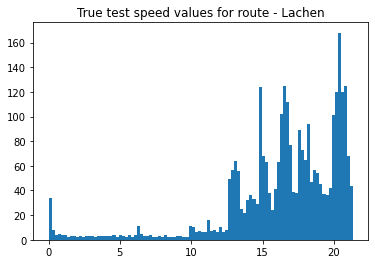

Model name -  resnet34


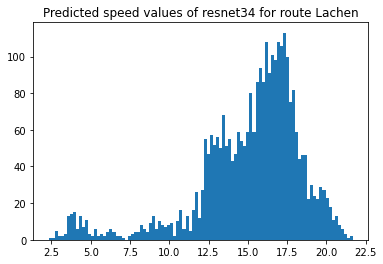

Model name -  resnext101_32x4d_ssl


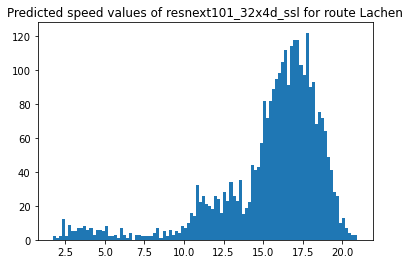

Model name -  resnext101_32x4d_swsl


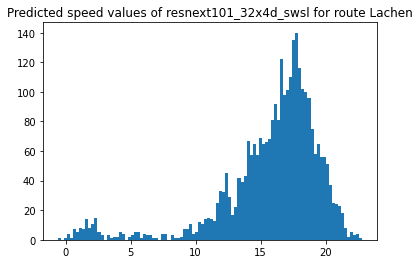

Model name -  simclr


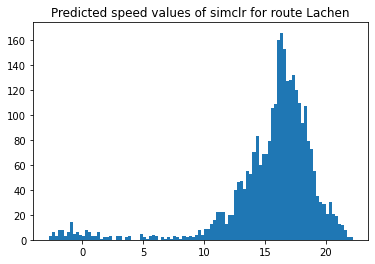

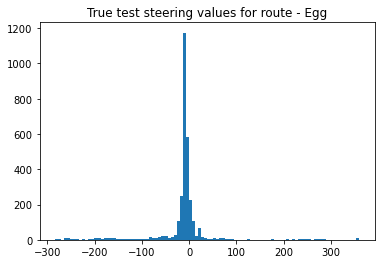

Model name -  resnet34


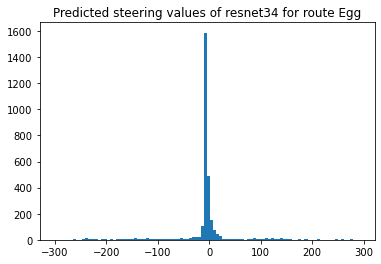

Model name -  resnext101_32x4d_ssl


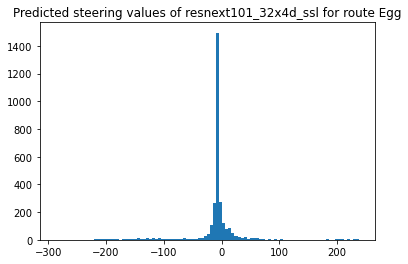

Model name -  resnext101_32x4d_swsl


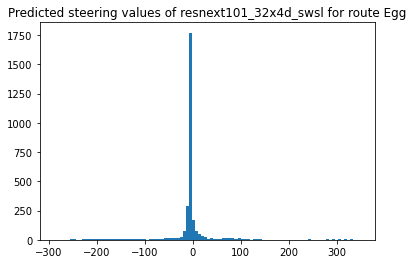

Model name -  simclr


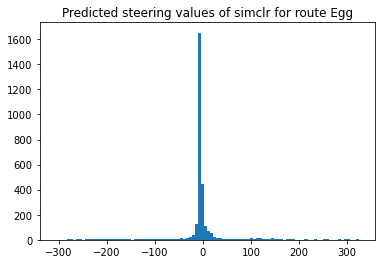

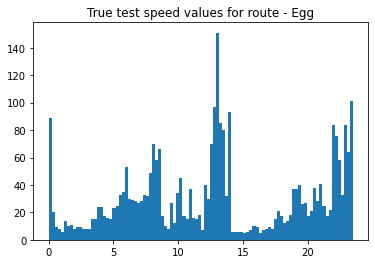

Model name -  resnet34


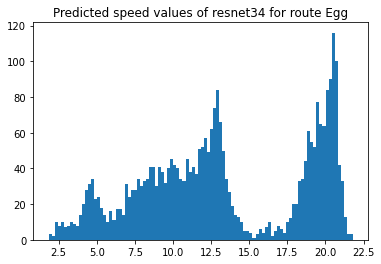

Model name -  resnext101_32x4d_ssl


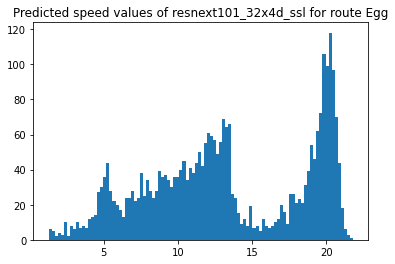

Model name -  resnext101_32x4d_swsl


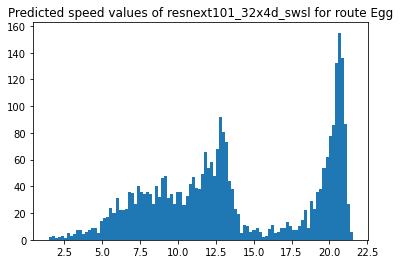

Model name -  simclr


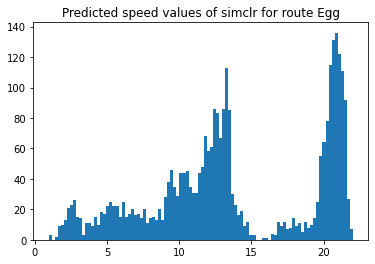

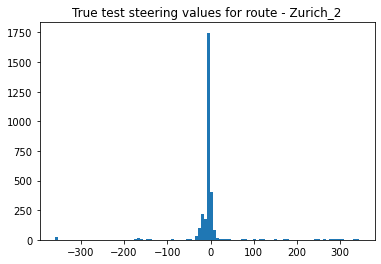

Model name -  resnet34


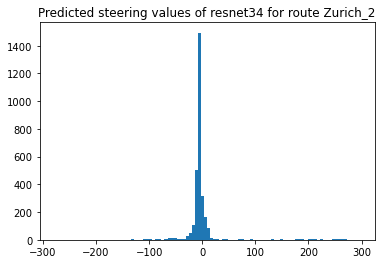

Model name -  resnext101_32x4d_ssl


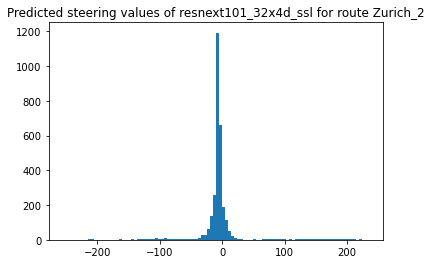

Model name -  resnext101_32x4d_swsl


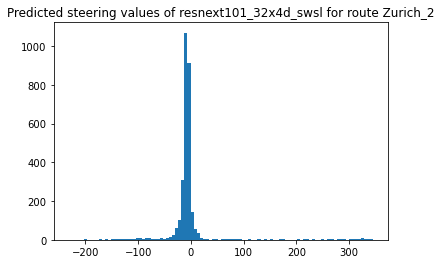

Model name -  simclr


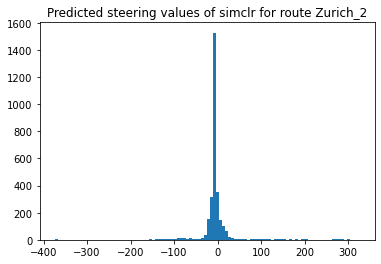

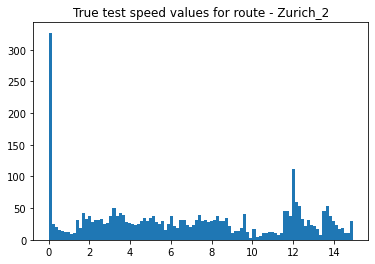

Model name -  resnet34


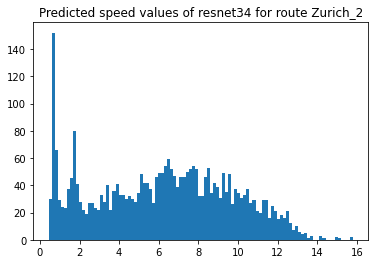

Model name -  resnext101_32x4d_ssl


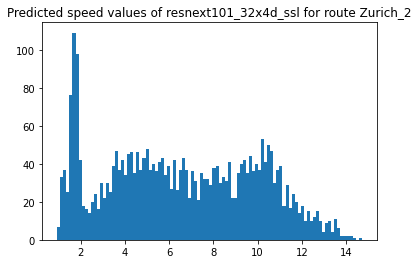

Model name -  resnext101_32x4d_swsl


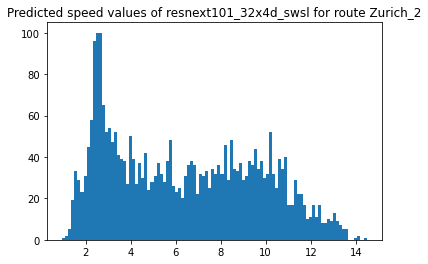

Model name -  simclr


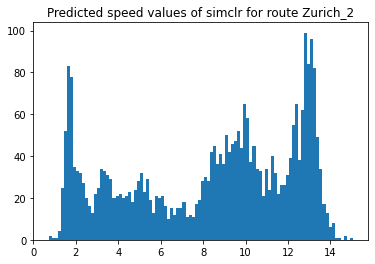

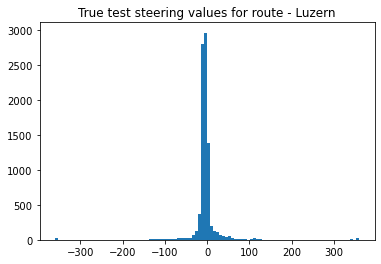

Model name -  resnet34


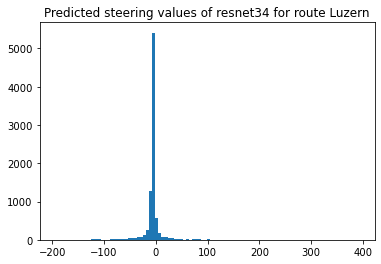

Model name -  resnext101_32x4d_ssl


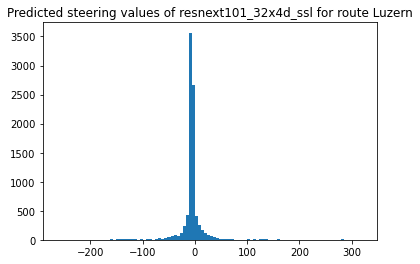

Model name -  resnext101_32x4d_swsl


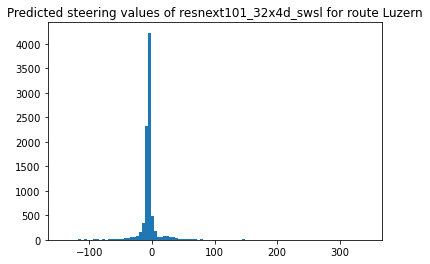

Model name -  simclr


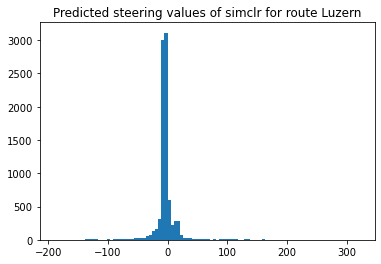

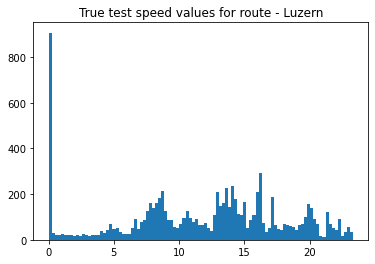

Model name -  resnet34


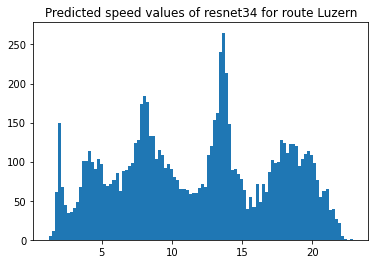

Model name -  resnext101_32x4d_ssl


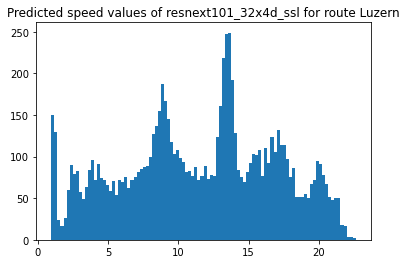

Model name -  resnext101_32x4d_swsl


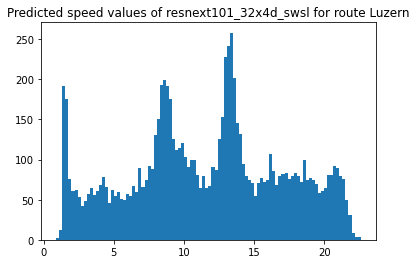

Model name -  simclr


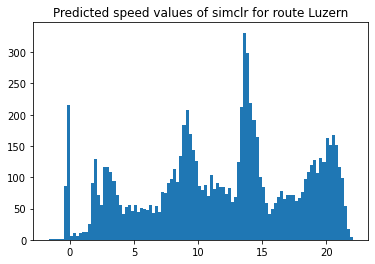

In [17]:
#Can pass a route and model names to the function to view histograms of ground truth test labels and model predictions for that route
#plot_route_level_histograms(df, 'Aargau', ['resnet', 'resnext_ssl', 'resnext_swsl'])

for route in route_list:
    plot_route_level_histograms(df, route, 
                                ['resnet34', 'resnext101_32x4d_ssl', 'resnext101_32x4d_swsl', 'simclr'])

Loading data from ./Drive360Images_160_90/drive360challenge_split_test_stratify.csv...
Phase: test # of data: 136080
Loading data from ./Drive360Images_160_90/drive360challenge_split_test_stratify.csv...
Phase: test # of data: 13613


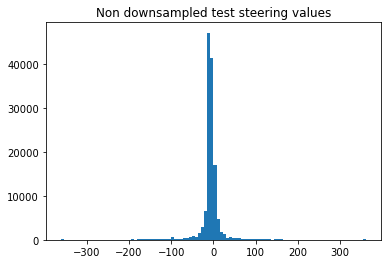

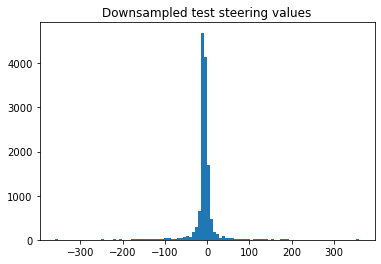

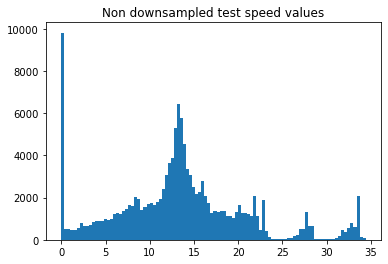

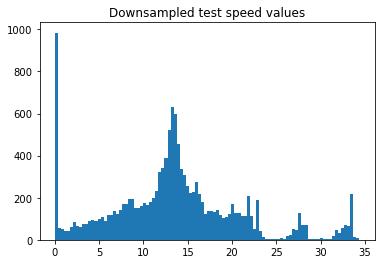

In [28]:
#Comparing histograms


In [ ]:
#Comparison of downsampled and non downsampled

# #Non-downsampled
# config = json.load(open('./config - load test data 2020-04-22.json'))
# test_loader = Drive360Loader(config, 'test')
# test_df = test_loader.drive360.dataframe.loc[test_loader.drive360.indices]
# test_steering_values = test_df['canSteering'].to_numpy()
# test_speed_values = test_df['canSpeed'].to_numpy()

# #Downsampled
# config = json.load(open('./config - load test data 2020-04-22-downsample.json'))
# test_loader_down = Drive360Loader(config, 'test')
# test_df_down = test_loader.drive360.dataframe.loc[test_loader_down.drive360.indices]
# test_steering_values_down = test_df_down['canSteering'].to_numpy()
# test_speed_values_down = test_df_down['canSpeed'].to_numpy()


# fig, ax = plt.subplots()
# ax.hist(test_steering_values, bins=100)
# ax.set_title("Non downsampled test steering values")
# plt.show()

# fig, ax = plt.subplots()
# ax.hist(test_steering_values_down, bins=100)
# ax.set_title("Downsampled test steering values")
# plt.show()

# fig, ax = plt.subplots()
# ax.hist(test_speed_values, bins=100)
# ax.set_title("Non downsampled test speed values")
# plt.show()

# fig, ax = plt.subplots()
# ax.hist(test_speed_values_down, bins=100)
# ax.set_title("Downsampled test speed values")
# plt.show()

In [15]:
sorted(list(set(routes)))

['Aargau',
 'Andelfingen',
 'Appenzell',
 'Appenzell_2',
 'Appenzell_3',
 'Bern',
 'ECCV_Test_4',
 'Egg',
 'Emmen',
 'Flims',
 'Flims_2',
 'Lachen',
 'Lachen_2',
 'Laufenburg',
 'Luzern',
 'Neuchatel',
 'Schaffhausen',
 'Zurich',
 'Zurich_2',
 'Zurich_3',
 'Zurich_4',
 'Zurich_5',
 'Zurich_6',
 'Zurich_8']

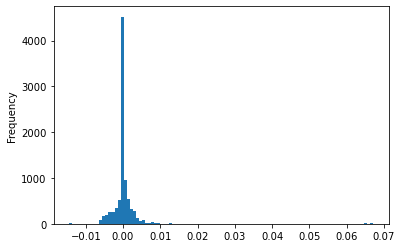

In [146]:
df_route.hereCurvature.plot.hist(bins=100)

In [142]:
df_route['curve_interval'] = pd.qcut(df_route.hereCurvature, q=10, precision=4)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
def mse(data, col1, col2):
    return np.mean(np.square(data[col1] - data[col2]))

In [28]:
models_to_plot = ['resnet34', 'resnext101_32x4d_ssl', 'resnext101_32x4d_swsl', 'simclr']

Text(0.5, 0.98, 'All Routes')

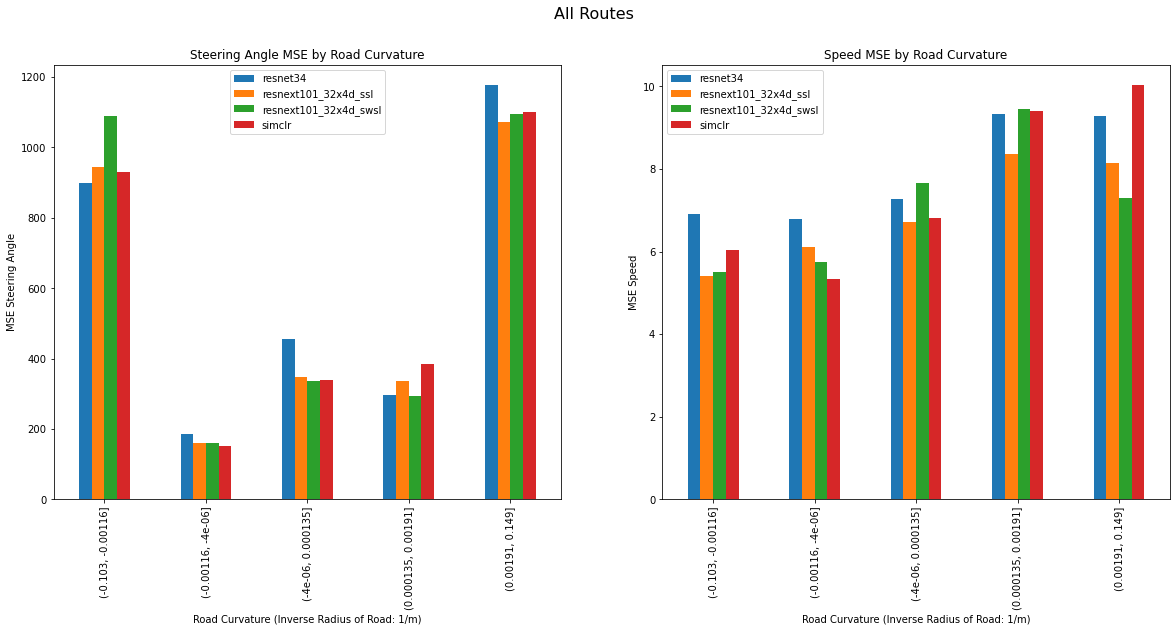

In [35]:
df_route = df.copy()
df_route['curve_interval'] = pd.qcut(df_route.hereCurvature, q=5, duplicates='drop')
steer_error = {}
speed_error = {}
for cat in df_route['curve_interval'].cat.categories:
    steer_error[cat]= [mse(df_route.loc[df_route['curve_interval'] == cat], 'true_steer', 'pred_steer_' + label) for label in models_to_plot]
    speed_error[cat]= [mse(df_route.loc[df_route['curve_interval'] == cat], 'true_speed', 'pred_speed_' + label) for label in models_to_plot]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_xlabel('Road Curvature (Inverse Radius of Road: 1/m)')
ax1.set_ylabel('MSE Steering Angle')
ax1.set_title('Steering Angle MSE by Road Curvature')
pd.DataFrame.from_dict(steer_error, orient='index', columns=models_to_plot).plot.bar(ax=ax1)

ax2.set_xlabel('Road Curvature (Inverse Radius of Road: 1/m)')
ax2.set_ylabel('MSE Speed')
ax2.set_title('Speed MSE by Road Curvature')
pd.DataFrame.from_dict(speed_error, orient='index', columns=models_to_plot).plot.bar(ax=ax2)

fig.suptitle("All Routes", fontsize=16)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


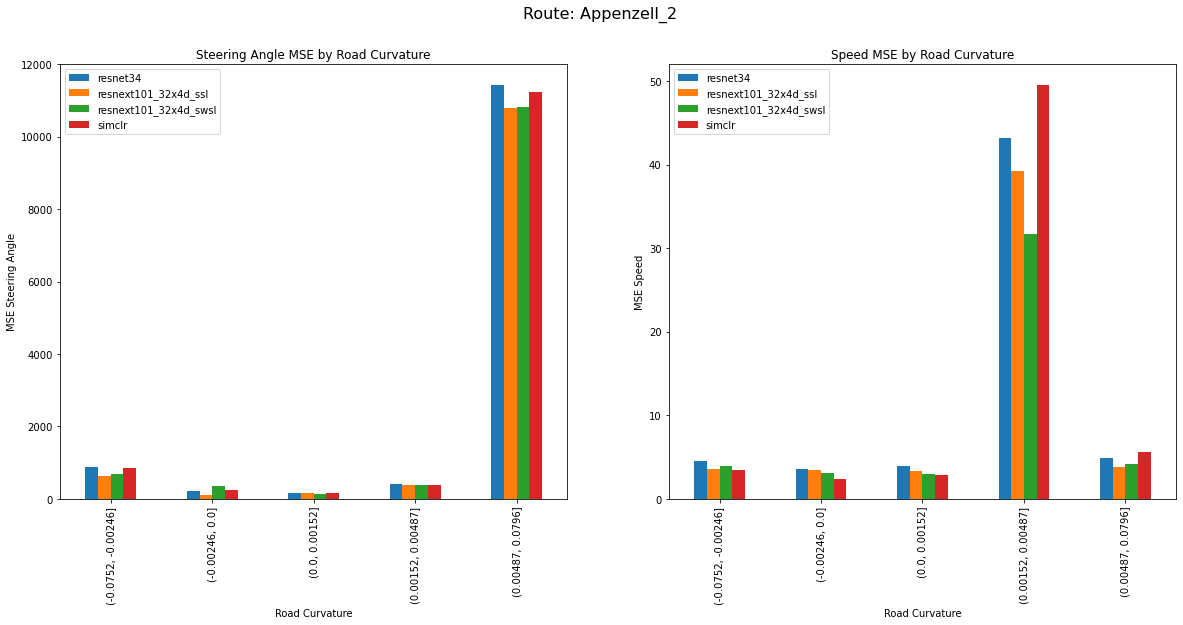

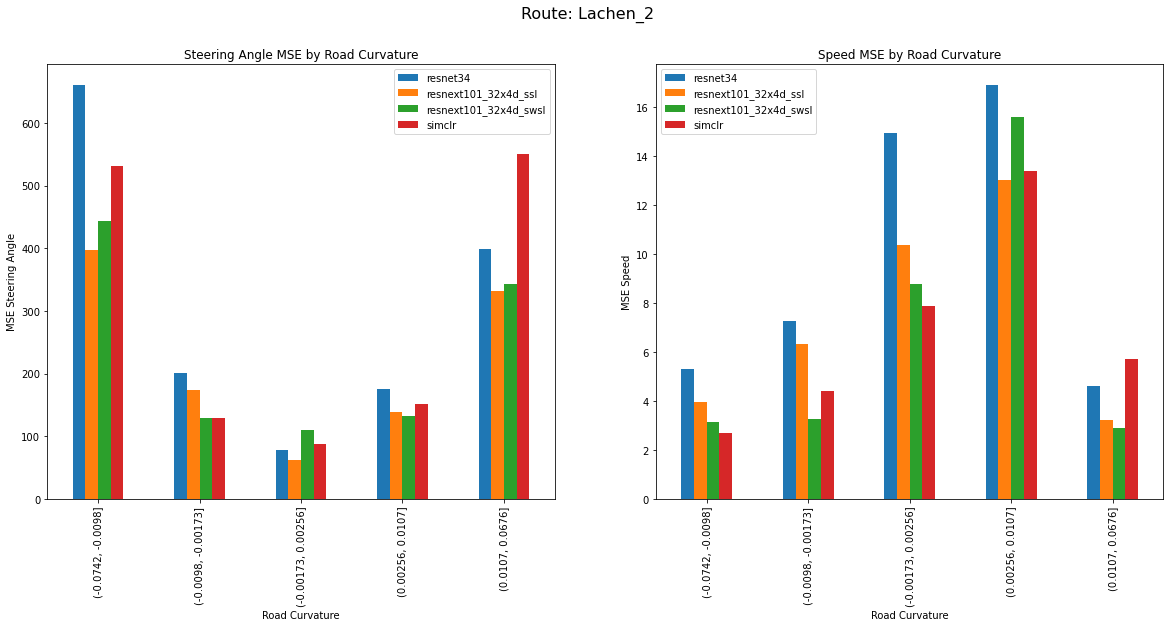

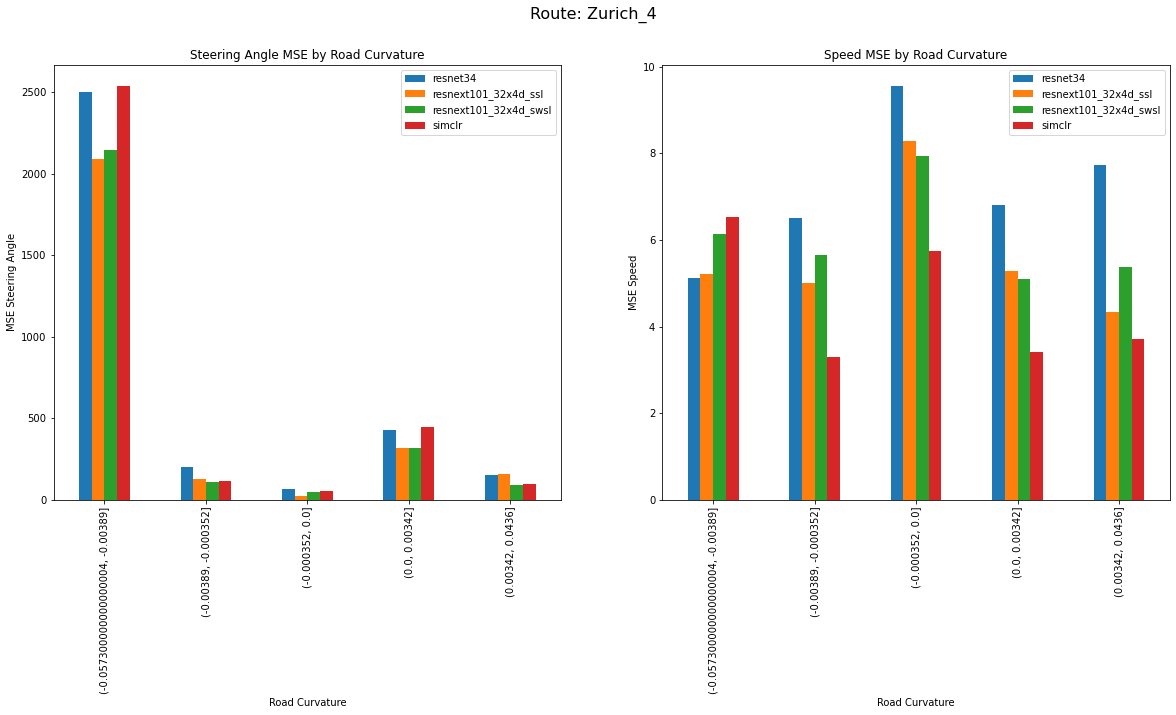

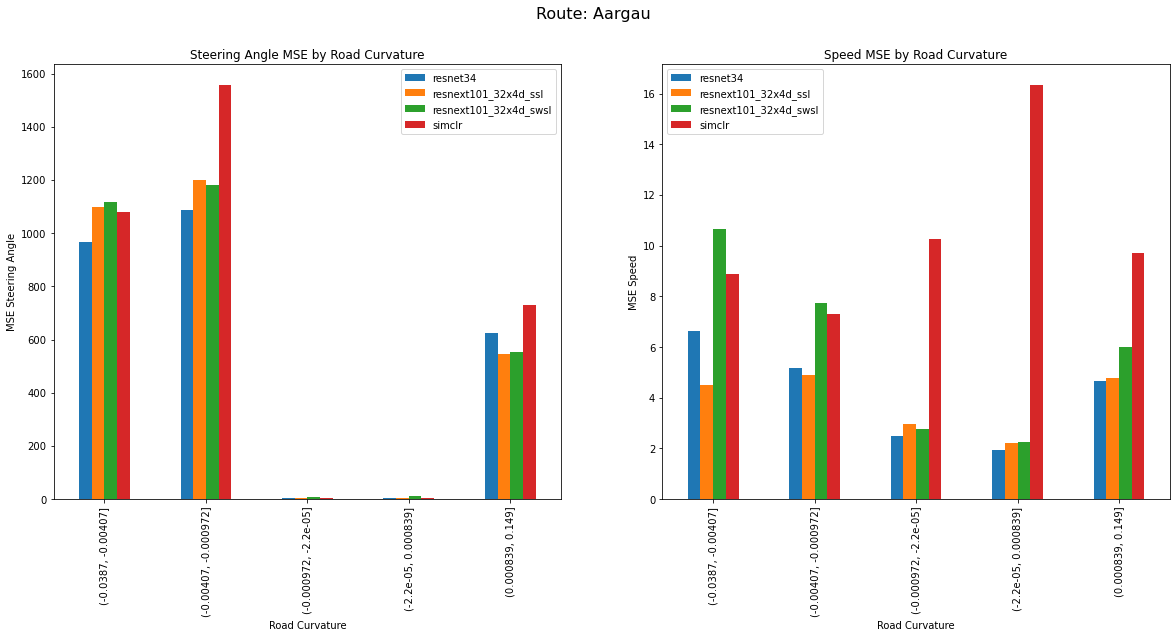

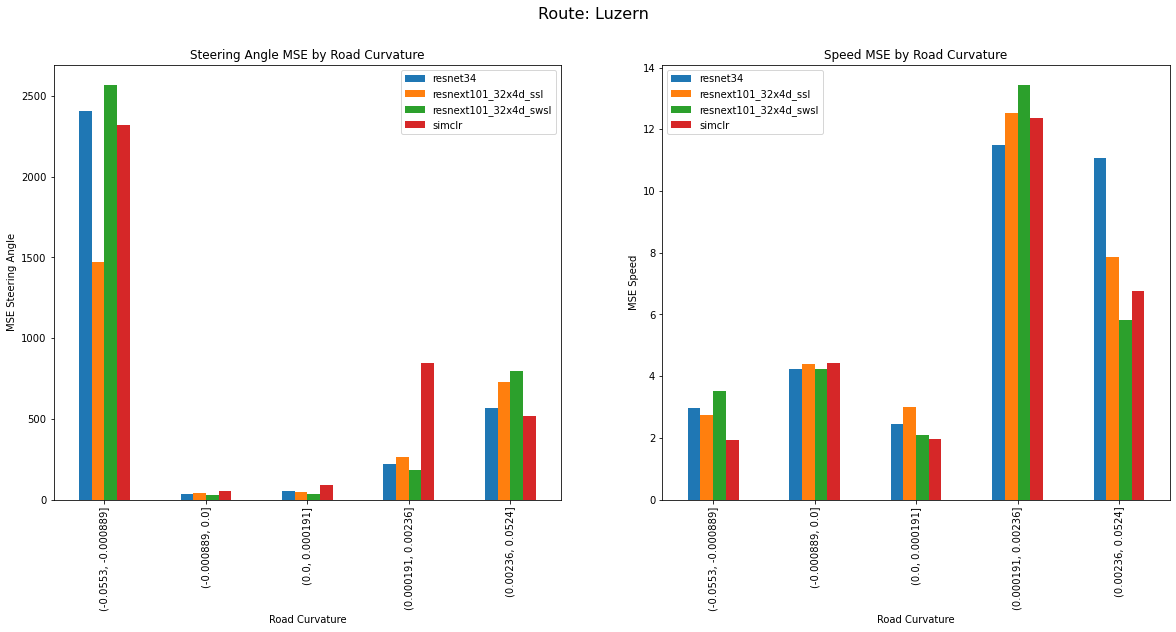

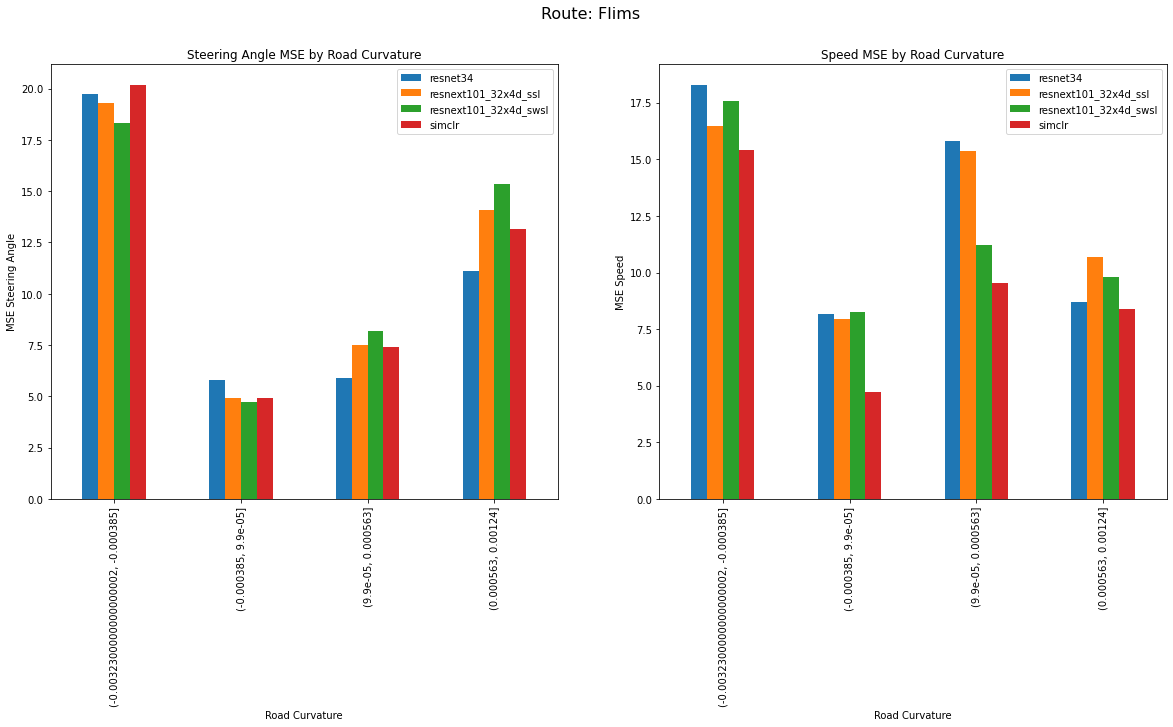

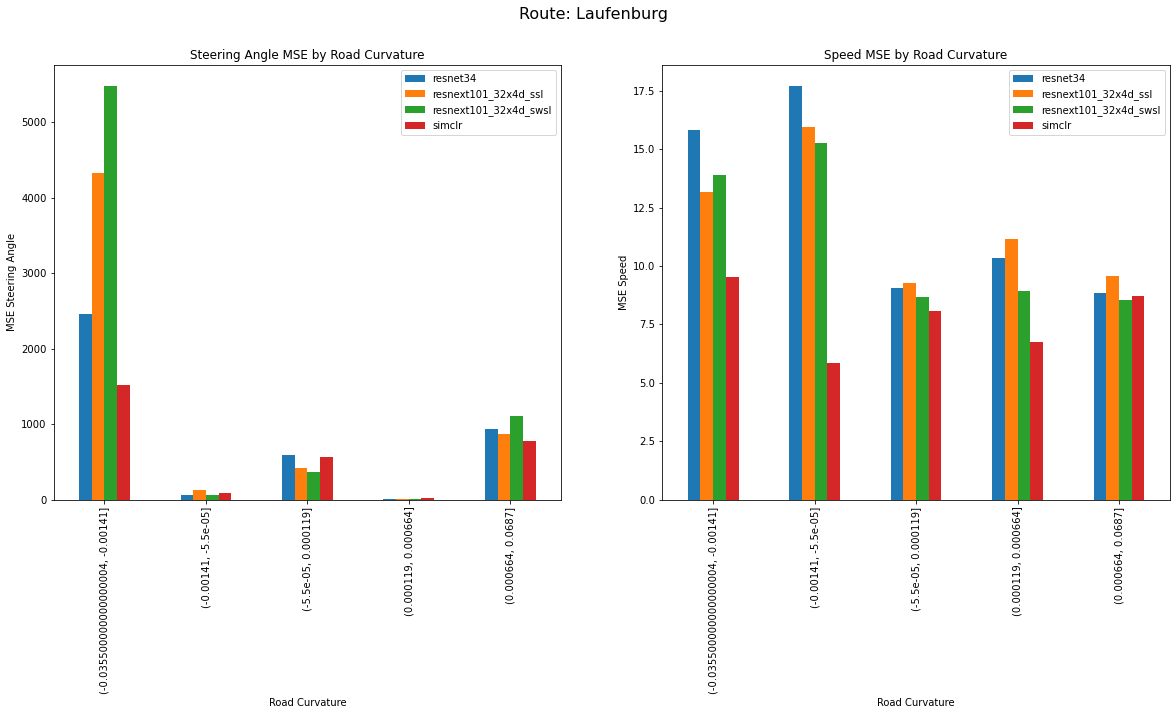

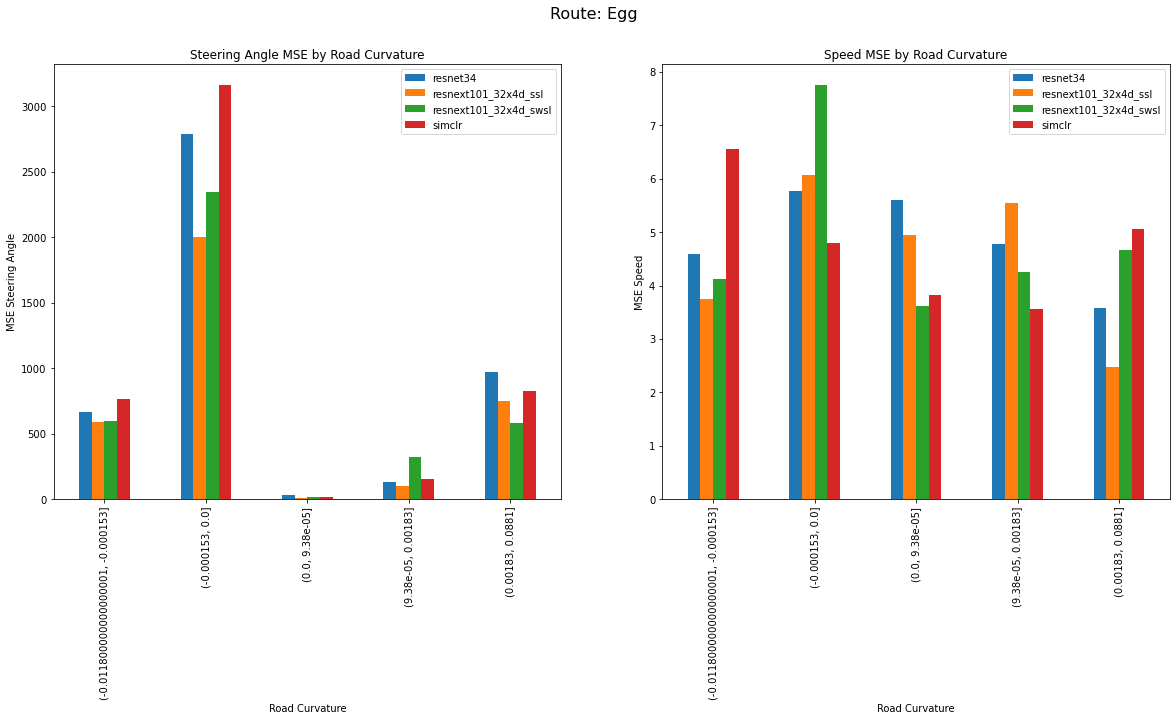

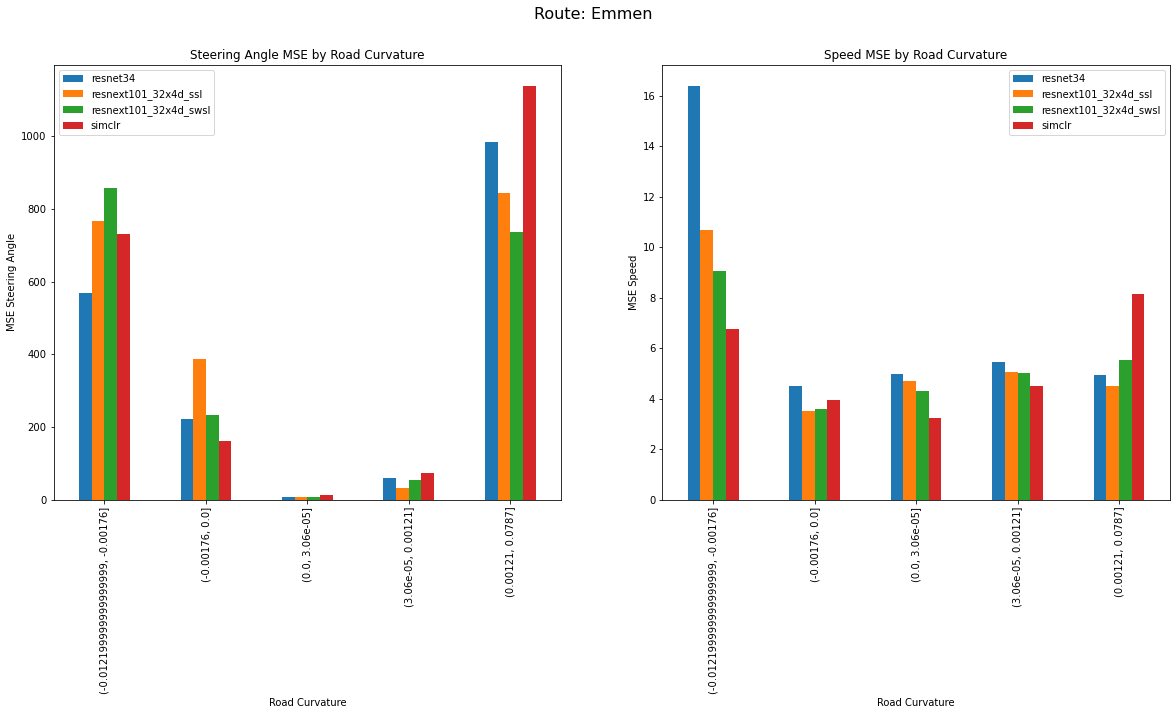

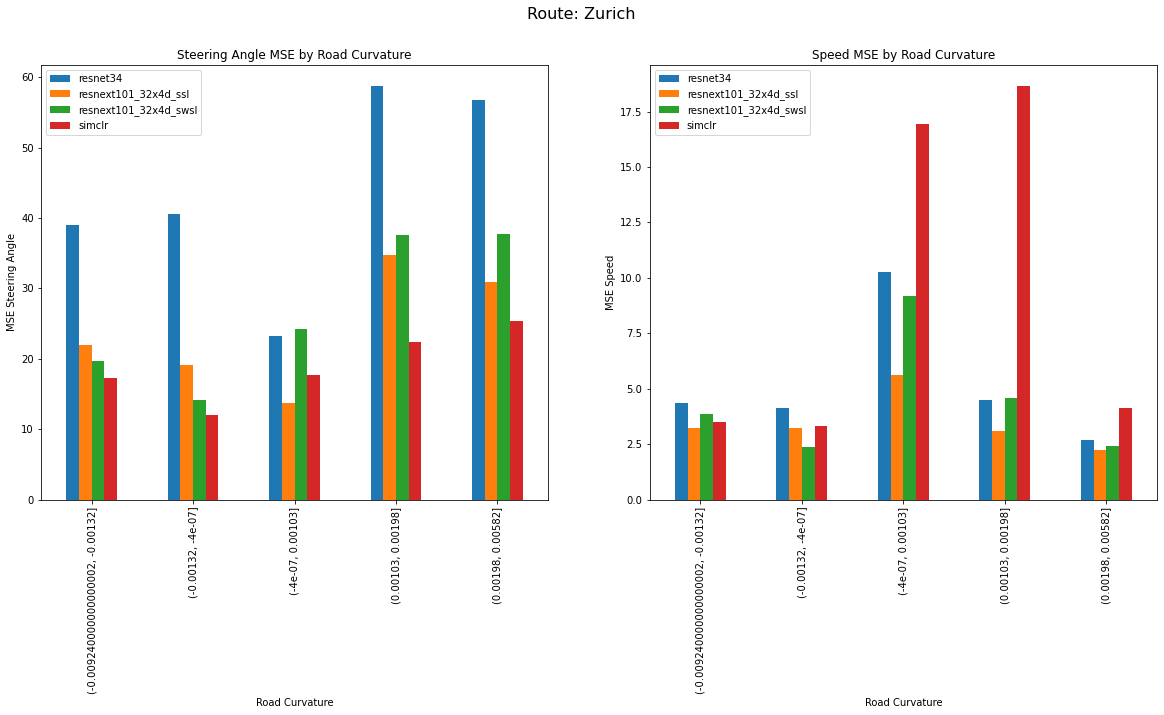

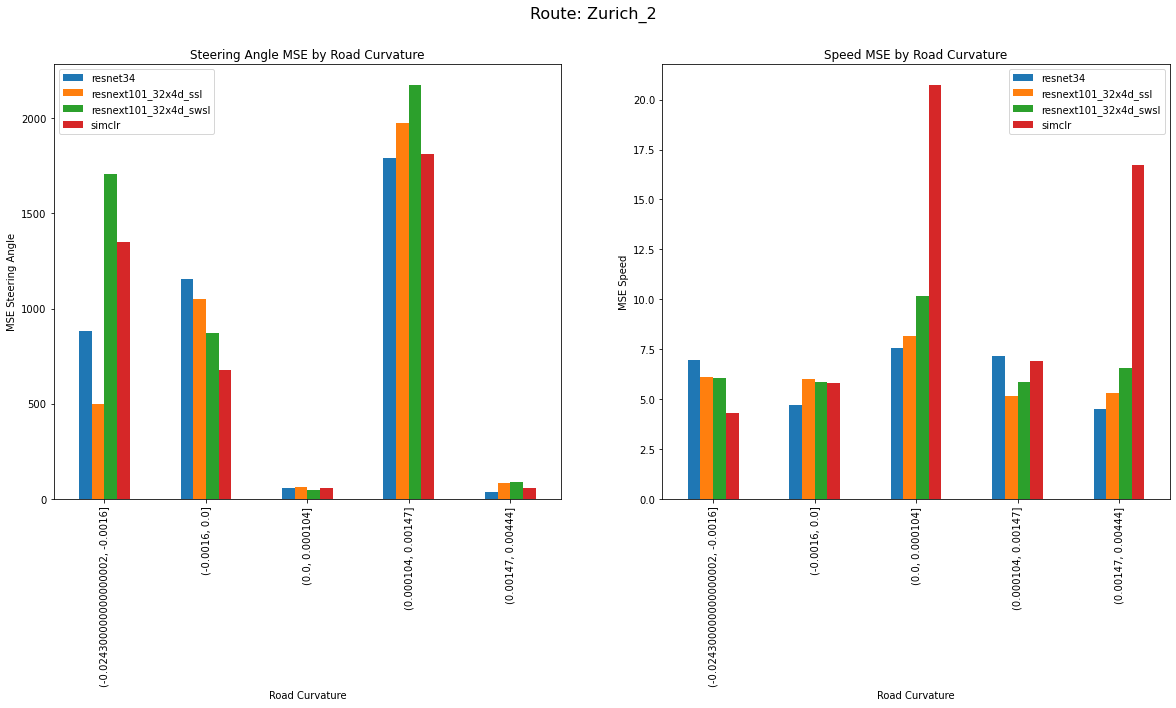

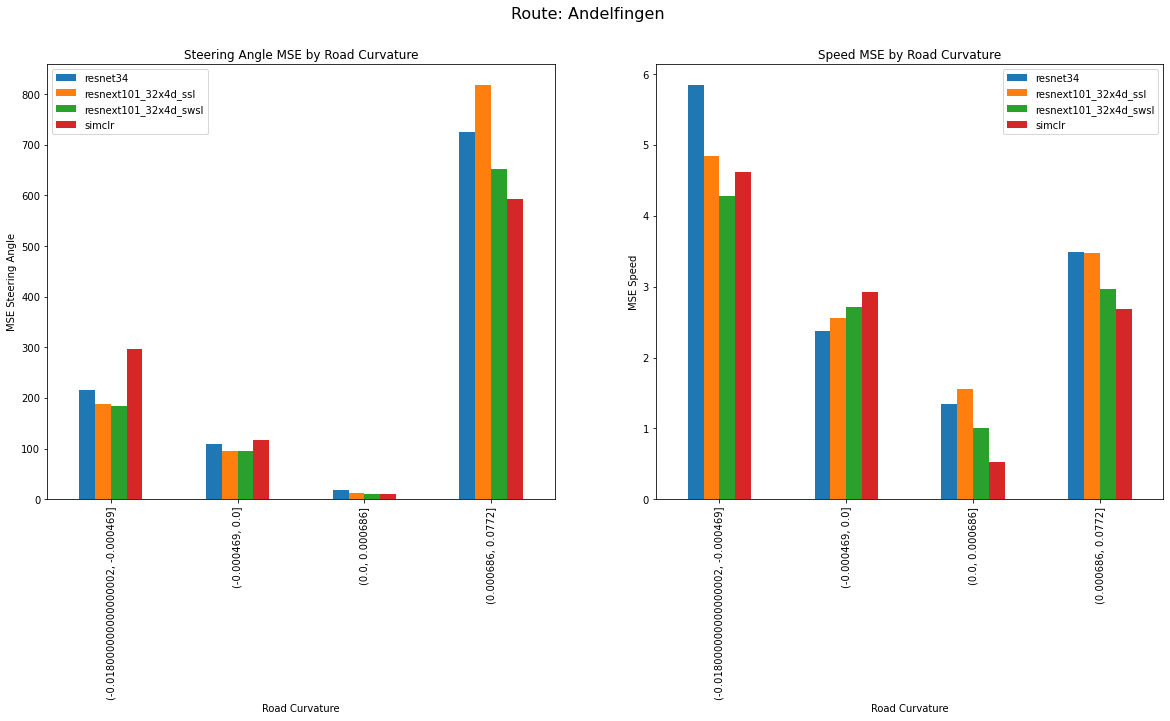

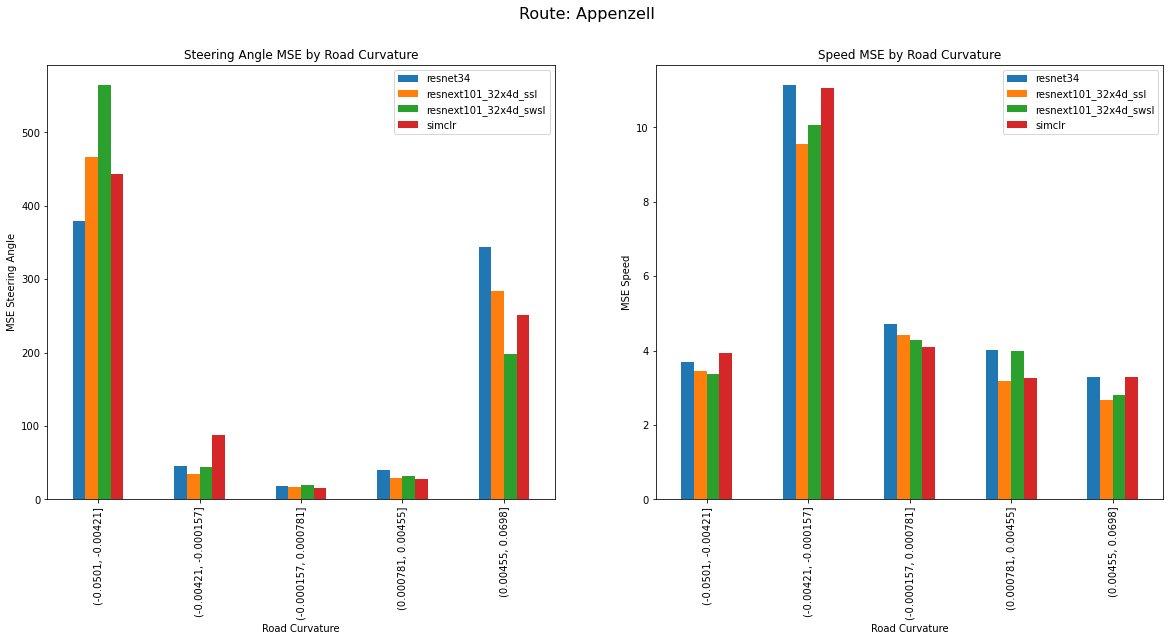

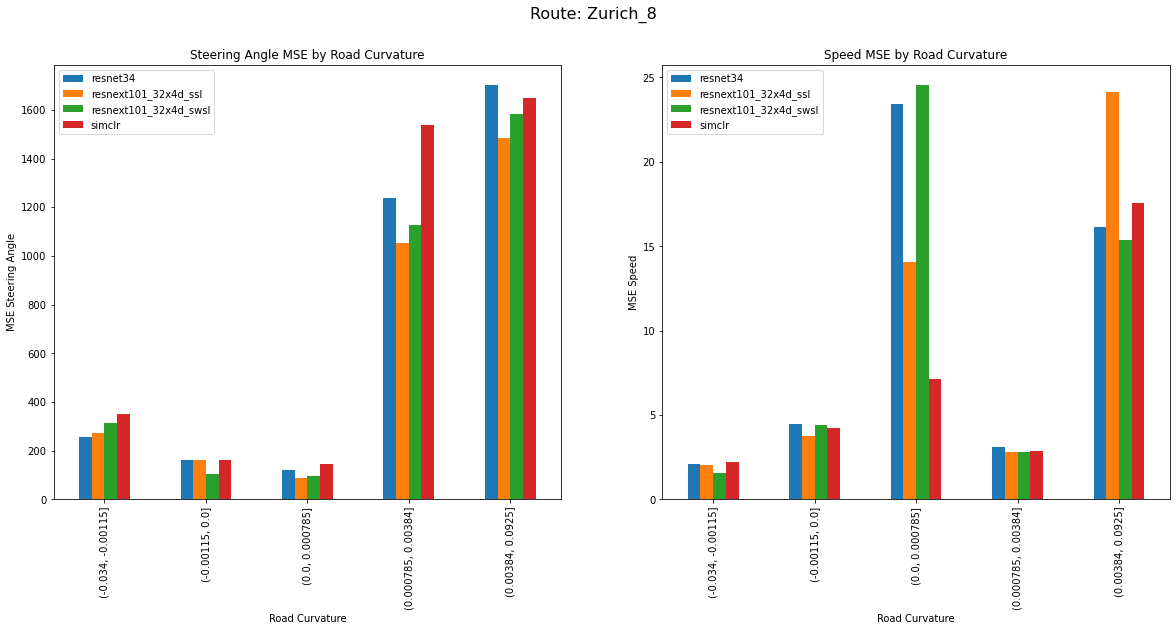

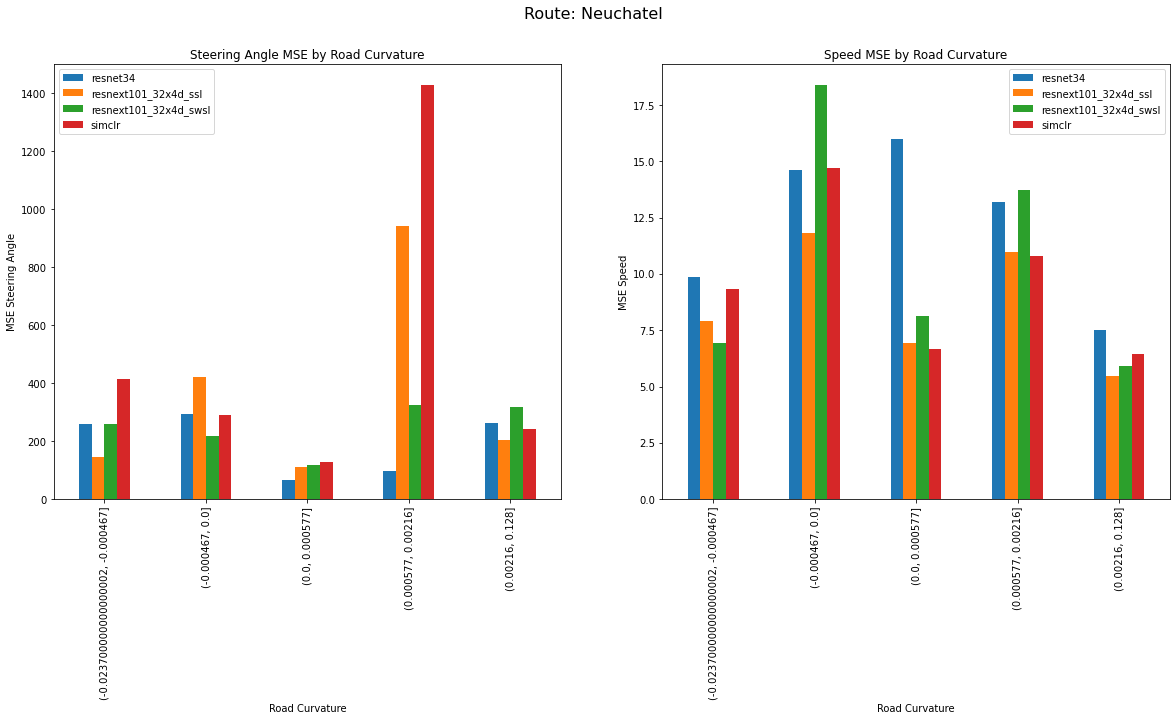

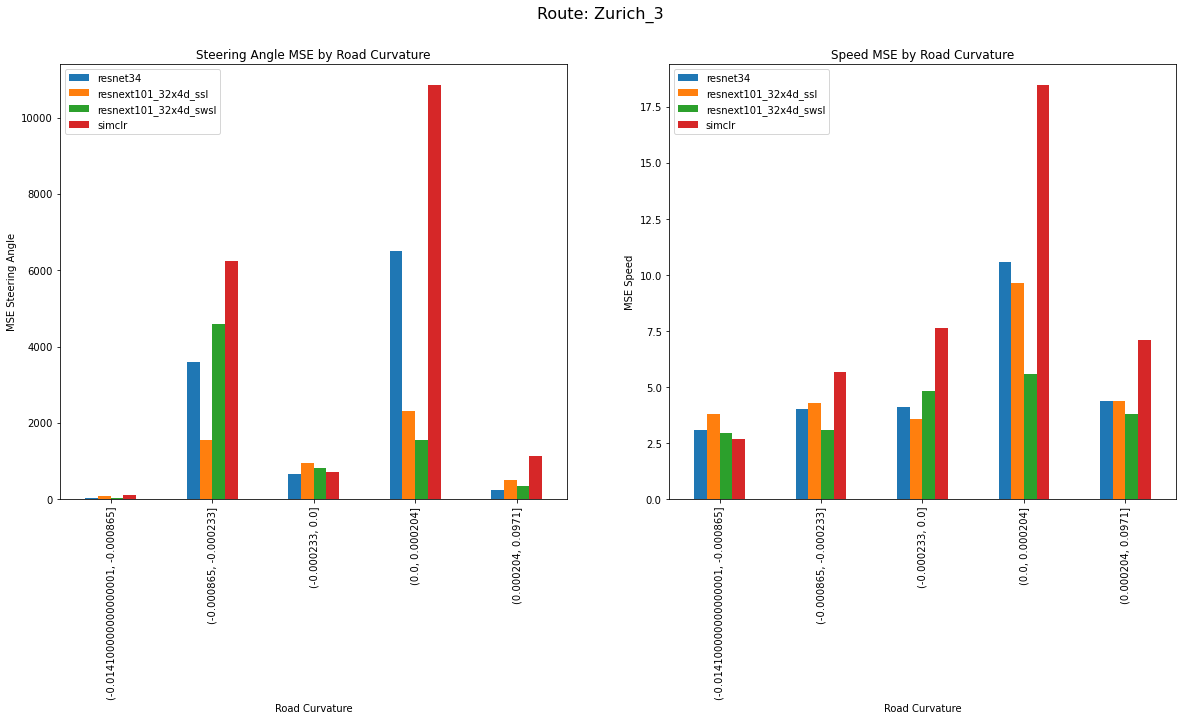

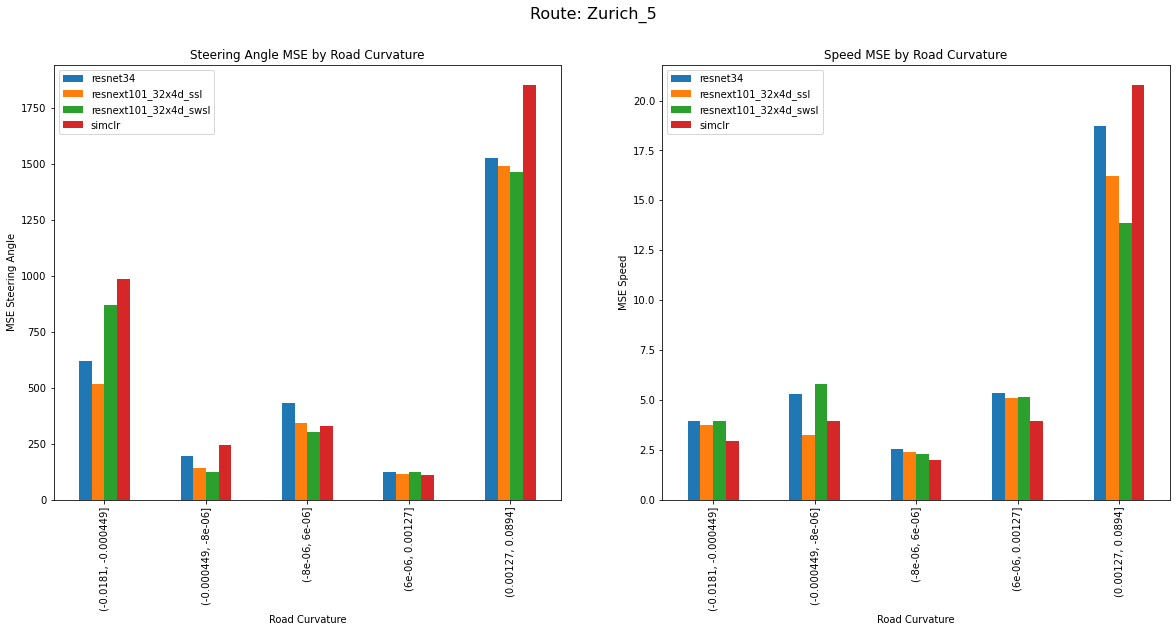

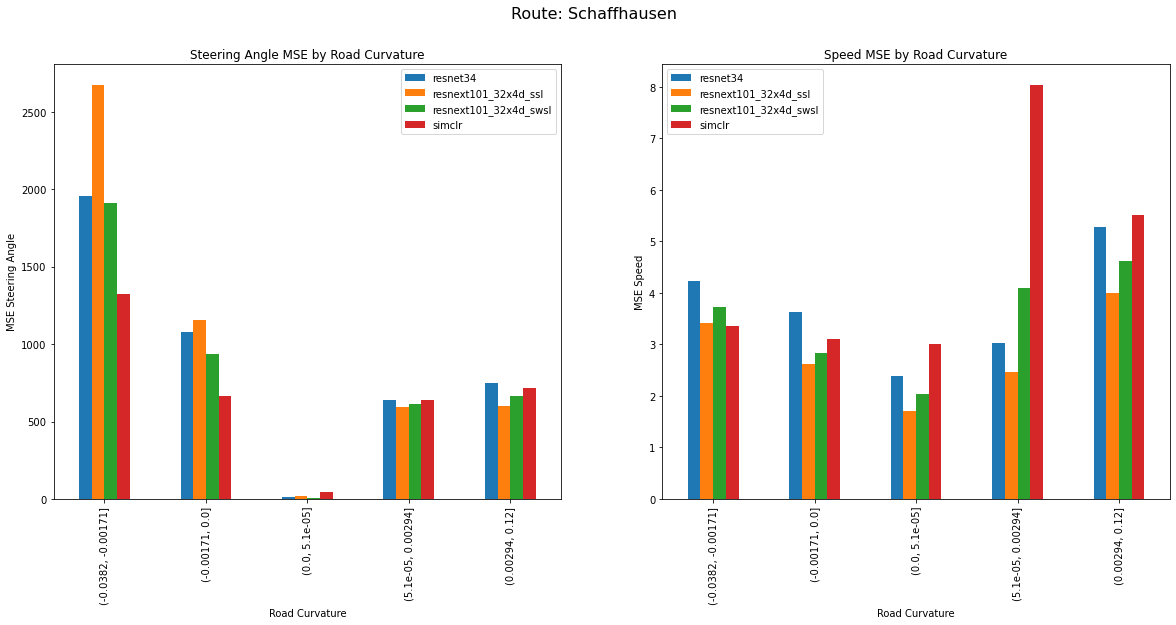

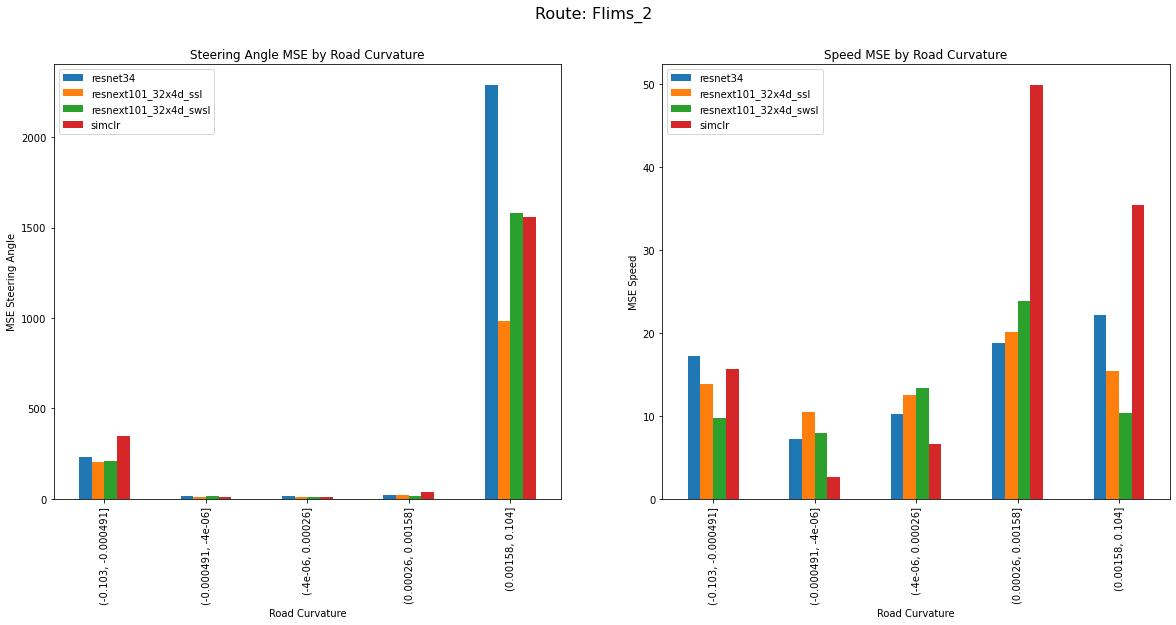

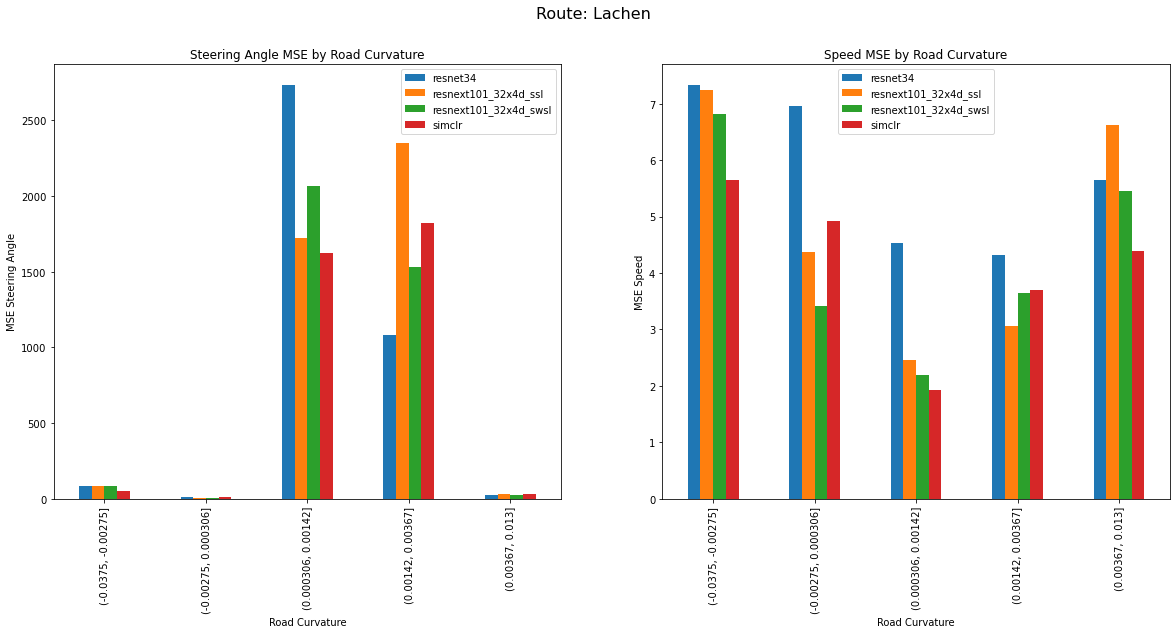

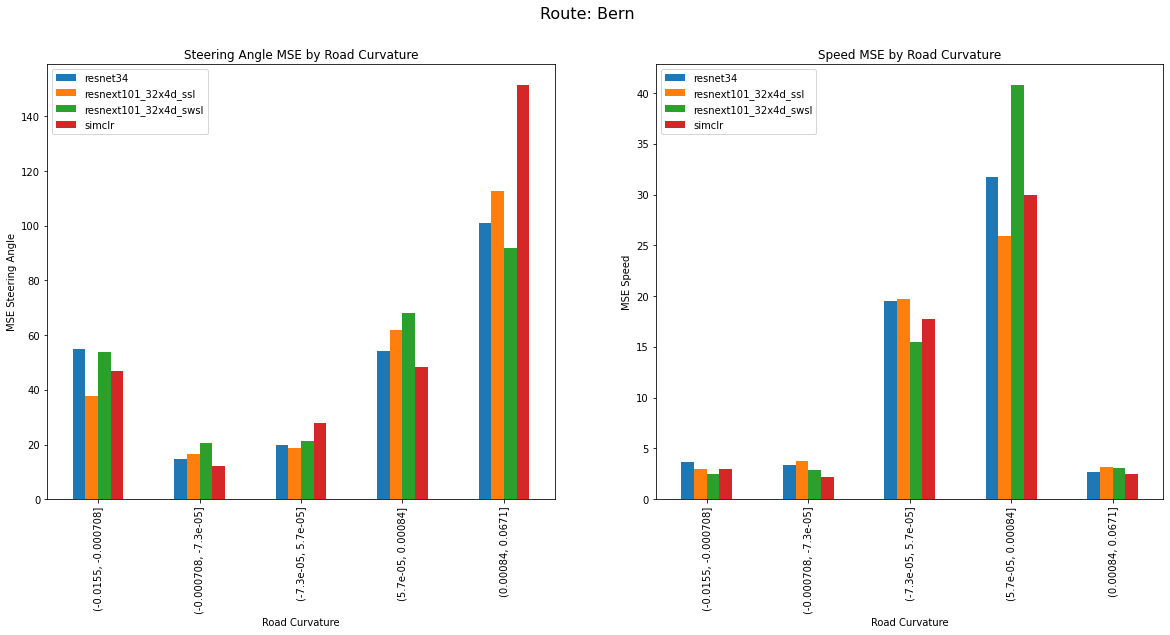

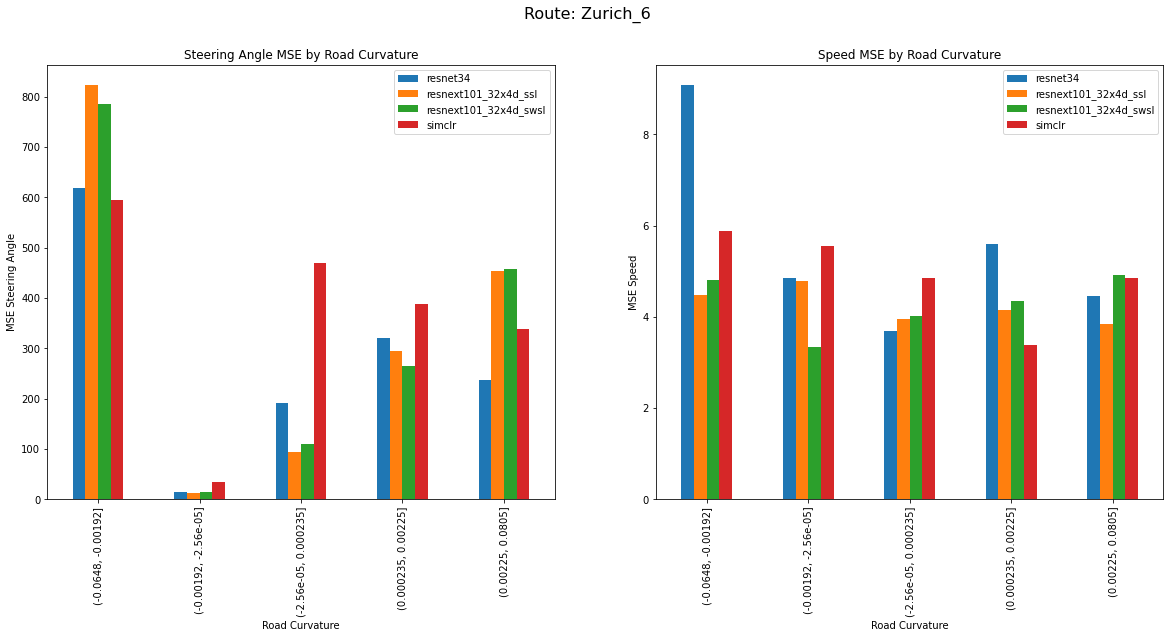

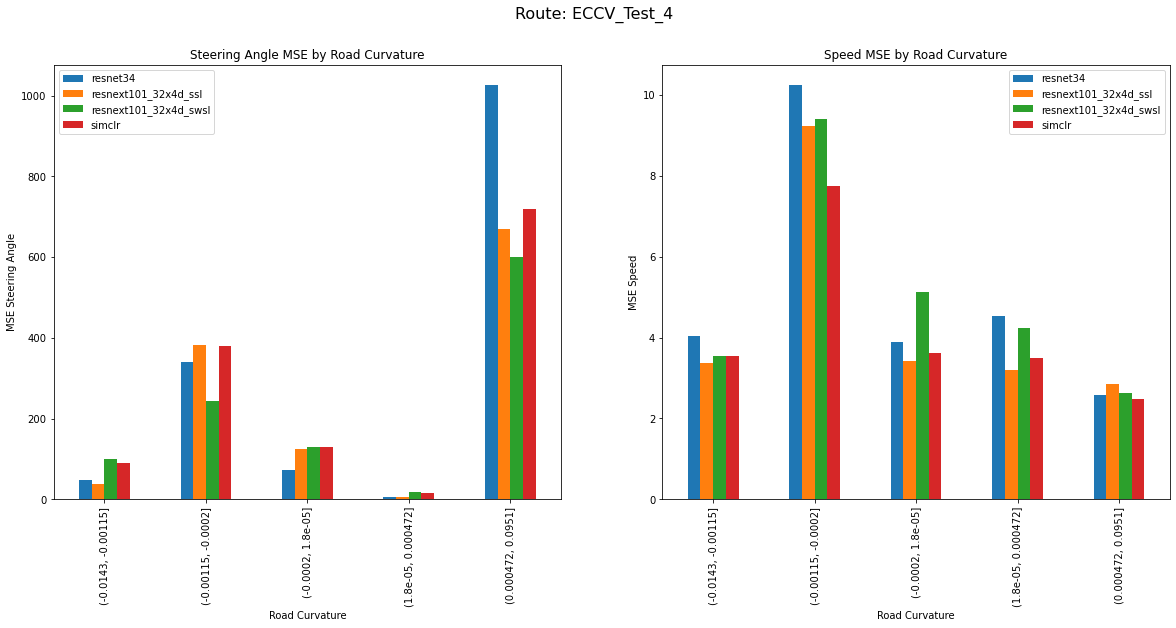

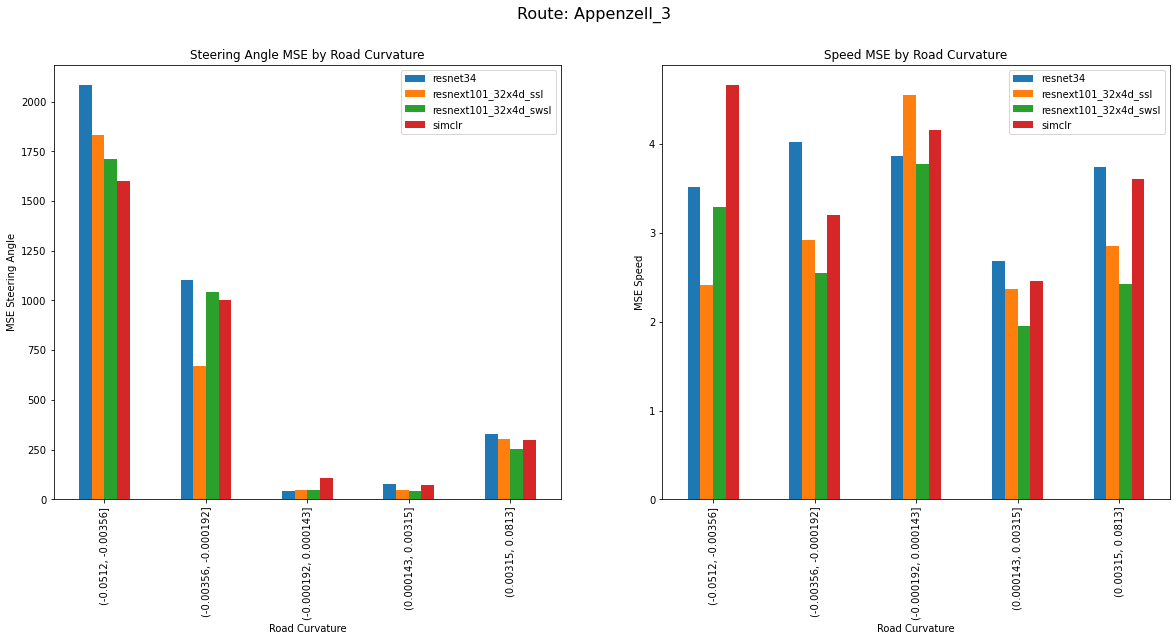

In [156]:
for route in list(set(routes)):
    df_route = df.loc[df['route'] == route]
    df_route['curve_interval'] = pd.qcut(df_route.hereCurvature, q=5, duplicates='drop')
    steer_error = {}
    speed_error = {}
    for cat in df_route['curve_interval'].cat.categories:
        steer_error[cat]= [mse(df_route.loc[df_route['curve_interval'] == cat], 'true_steer', 'pred_steer_' + label) for label in models_to_plot]
        speed_error[cat]= [mse(df_route.loc[df_route['curve_interval'] == cat], 'true_speed', 'pred_speed_' + label) for label in models_to_plot]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1.set_xlabel('Road Curvature')
    ax1.set_ylabel('MSE Steering Angle')
    ax1.set_title('Steering Angle MSE by Road Curvature')
    pd.DataFrame.from_dict(steer_error, orient='index', columns=models_to_plot).plot.bar(ax=ax1)

    ax2.set_xlabel('Road Curvature')
    ax2.set_ylabel('MSE Speed')
    ax2.set_title('Speed MSE by Road Curvature')
    pd.DataFrame.from_dict(speed_error, orient='index', columns=models_to_plot).plot.bar(ax=ax2)
    
    fig.suptitle("Route: " + route, fontsize=16)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3b45cf510>,
      dtype=object)

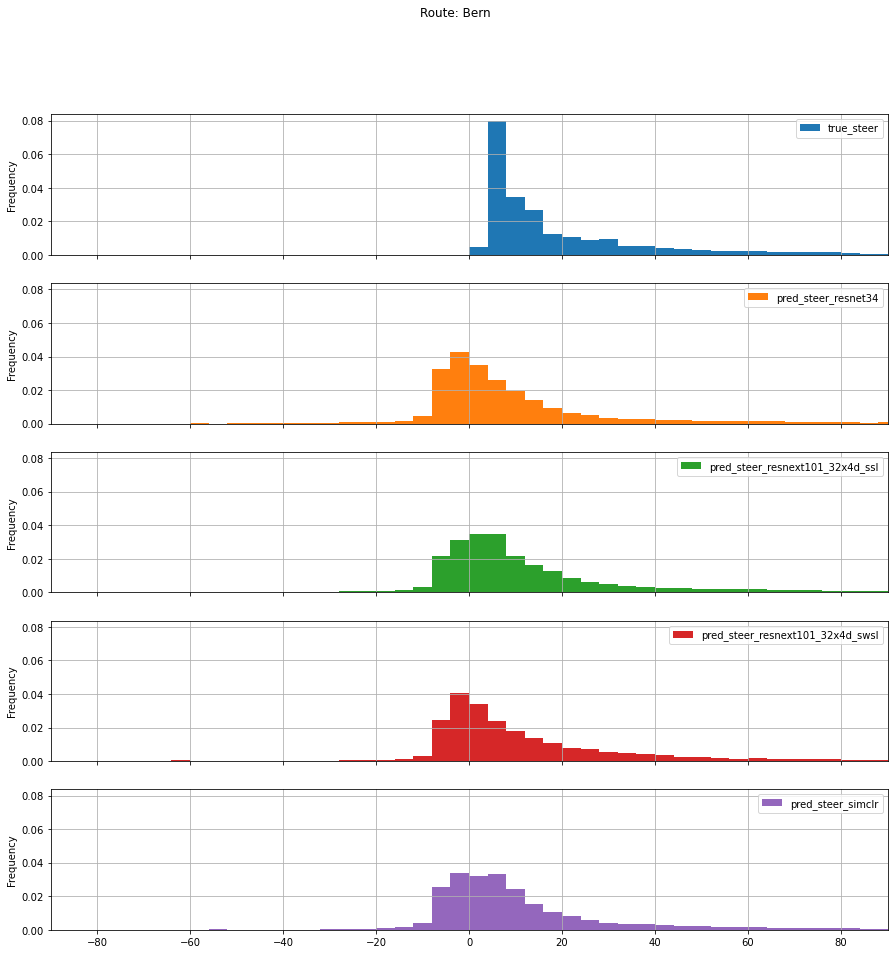

In [162]:
route = 'Bern'
# df_route = df.loc[df['route'] == route]
df_route = df[df.true_steer > 0].copy()

df_route[[c for c in df_route.columns if 'steer' in c]].plot.hist(bins=np.arange(-360, 360, 4),
                      subplots=True,
                      sharex=True,
                      sharey=True,
                      figsize=(15, 15),
                      grid=True,
                      title='Route: ' + route,
                      xlim=(-90, 90),
                      density=True)